#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from folium import Choropleth
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [ ]:
#Loading Storm Data Files:All data files have been pulled from the national storm events database as updated on 2.16.25
details = pd.read_csv("/content/drive/MyDrive/Data_Files/StormEvents_details-ftp_v1.0_d2024_c20250216.csv.gz", compression="gzip")
fatalities = pd.read_csv("/content/drive/MyDrive/Data_Files/StormEvents_fatalities-ftp_v1.0_d2024_c20250216.csv.gz", compression="gzip")
locations = pd.read_csv("/content/drive/MyDrive/Data_Files/StormEvents_locations-ftp_v1.0_d2024_c20250216.csv.gz", compression="gzip")
#shapefile=gpd.read_file("/content/cb_2023_us_county_500k.zip")

# STORM DETAILS

In [ ]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67036 entries, 0 to 67035
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BEGIN_YEARMONTH     67036 non-null  int64  
 1   BEGIN_DAY           67036 non-null  int64  
 2   BEGIN_TIME          67036 non-null  int64  
 3   END_YEARMONTH       67036 non-null  int64  
 4   END_DAY             67036 non-null  int64  
 5   END_TIME            67036 non-null  int64  
 6   EPISODE_ID          67036 non-null  int64  
 7   EVENT_ID            67036 non-null  int64  
 8   STATE               67036 non-null  object 
 9   STATE_FIPS          67036 non-null  int64  
 10  YEAR                67036 non-null  int64  
 11  MONTH_NAME          67036 non-null  object 
 12  EVENT_TYPE          67036 non-null  object 
 13  CZ_TYPE             67036 non-null  object 
 14  CZ_FIPS             67036 non-null  int64  
 15  CZ_NAME             67036 non-null  object 
 16  WFO 

In [ ]:
from IPython.display import display

display(details)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,202405,23,1947,202405,23,1947,190907,1180619,OKLAHOMA,40,2024,May,Hail,C,65,JACKSON,OUN,23-MAY-24 19:47:00,CST-6,23-MAY-24 19:47:00,0,0,0,0,NaN,NaN,Public,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,S,FRIENDSHIP,4.0,S,FRIENDSHIP,34.6380,-99.2167,34.6380,-99.2167,Two primary rounds of severe convection occurr...,MPing report.,CSV
1,202411,16,230,202411,18,1421,197838,1223377,OREGON,41,2024,November,Heavy Snow,Z,509,EAST SLOPES OF THE OREGON CASCADES,PDT,16-NOV-24 02:30:00,PST-8,18-NOV-24 14:21:00,0,0,0,0,0.00K,0.00K,SNOTEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A series of cold fronts the weekend of Nov. 16...,The Hog Pass SNOTEL reported an estimated 12 i...,CSV
2,202405,19,1839,202405,19,1902,190905,1184919,OKLAHOMA,40,2024,May,Tornado,C,39,CUSTER,OUN,19-MAY-24 18:39:00,CST-6,19-MAY-24 19:02:00,0,0,0,0,150.00K,0.00K,NWS Storm Survey,NaN,NaN,NaN,NaN,EF1,6.7,400.0,NaN,NaN,NaN,NaN,8.0,WNW,CUSTER CITY,5.0,N,CUSTER CITY,35.7100,-99.0010,35.7370,-98.8910,Significant severe weather occurred across por...,While the large multiple-vortex tornado was ap...,CSV
3,202405,23,2155,202405,23,2155,190907,1180805,OKLAHOMA,40,2024,May,Thunderstorm Wind,C,51,GRADY,OUN,23-MAY-24 21:55:00,CST-6,23-MAY-24 21:55:00,0,0,0,0,10.00K,NaN,Other Federal Agency,61.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,W,NINNEKAH,2.0,W,NINNEKAH,34.9501,-97.9523,34.9501,-97.9523,Two primary rounds of severe convection occurr...,Relayed image showing a portable outbuilding b...,CSV
4,202411,22,400,202411,22,1100,197326,1220680,NEW YORK,36,2024,November,Winter Weather,Z,67,ORANGE,OKX,22-NOV-24 04:00:00,EST-5,22-NOV-24 11:00:00,0,0,0,0,0.00K,0.00K,Trained Spotter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An occluded low pressure system brought heavy ...,A trained spotter reported 10.0 inches of wet ...,CSV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67031,202407,4,1500,202407,4,1600,195150,1206283,ALABAMA,1,2024,July,Excessive Heat,Z,16,CULLMAN,HUN,04-JUL-24 15:00:00,CST-6,04-JUL-24 16:00:00,0,0,0,0,0.00K,0.00K,AWOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heat index values reached 105 to 109 degrees f...,The heat index peaked at 110 degrees for a sho...,CSV
67032,202407,4,1100,202407,4,1800,195150,1206284,ALABAMA,1,2024,July,Heat,Z,16,CULLMAN,HUN,04-JUL-24 11:00:00,CST-6,04-JUL-24 18:00:00,0,0,0,0,0.00K,0.00K,AWOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heat index values reached 105 to 109 degrees f...,The heat index reached 105 to 109 degrees.,CSV
67033,202407,6,1258,202407,6,1258,192857,1198392,NEBRASKA,31,2024,July,Hail,C,47,DAWSON,GID,06-JUL-24 12:58:00,CST-6,06-JUL-24 12:58:00,0,0,0,0,0.00K,0.00K,Public,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,SW,LEXINGTON ARPT,8.0,SW,LEXINGTON ARPT,40.7100,-99.8800,40.7100,-99.8800,"A broad, upper trough was over most of the cou...",NaN,CSV
67034,202407,6,1523,202407,6,1535,192857,1198427,NEBRASKA,31,2024,July,Thunderstorm Wind,C,1,ADAMS,GID,06-JUL-24 15:23:00,CST-6,06-JUL-24 15:35:00,0,0,0,0,15.00K,0.00K,ASOS,60.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N,(HSI)HASTINGS ARPT,1.0,SE,HAS

In [ ]:
#Converts the data to from int to date/time
details['Begin_YearMonth'] = pd.to_datetime(details['BEGIN_YEARMONTH'], format='%Y%m')

In [ ]:
#There are 67,036 records of storm events that were recorded from the beginning of 1/1/2024 to 11/1/2024
details['Begin_YearMonth'].describe()

,Begin_YearMonth
count,67036
mean,2024-05-16 02:51:28.967121920
min,2024-01-01 00:00:00
25%,2024-04-01 00:00:00
50%,2024-06-01 00:00:00
75%,2024-07-01 00:00:00
max,2024-11-01 00:00:00


In [ ]:
#Converts the data to from int to date/time
details['End_YearMonth'] = pd.to_datetime(details['END_YEARMONTH'], format='%Y%m')

In [ ]:
#There are 67,036 records of storm events that were recorded from the beginning of 1/1/2024 to 11/1/2024
details['End_YearMonth'].describe()

,End_YearMonth
count,67036
mean,2024-05-16 02:51:28.967121920
min,2024-01-01 00:00:00
25%,2024-04-01 00:00:00
50%,2024-06-01 00:00:00
75%,2024-07-01 00:00:00
max,2024-11-01 00:00:00


In [ ]:
details['BEGIN_DATE_TIME'].head()

,BEGIN_DATE_TIME
0,23-MAY-24 19:47:00
1,16-NOV-24 02:30:00
2,19-MAY-24 18:39:00
3,23-MAY-24 21:55:00
4,22-NOV-24 04:00:00


In [ ]:

# Convert to datetime
details['BEGIN_DATE_TIME'] = pd.to_datetime(details['BEGIN_DATE_TIME'], format='%d-%b-%y %H:%M:%S', errors='coerce')
details['END_DATE_TIME'] = pd.to_datetime(details['END_DATE_TIME'], format='%d-%b-%y %H:%M:%S', errors='coerce')

# Deriving storm duration
details['DURATION_MINUTES'] = (details['END_DATE_TIME'] - details['BEGIN_DATE_TIME']).dt.total_seconds() / 60

details['DURATION_MINUTES'].describe()


,DURATION_MINUTES
count,67036.000000
mean,2231.550928
std,8072.408781
min,0.000000
25%,0.000000
50%,6.000000
75%,540.000000
max,44639.000000


In [ ]:
# Standardize EVENT_TYPE first
details['EVENT_TYPE'] = details['EVENT_TYPE'].str.upper().str.strip()

# Now create the IS_TORNADO flag (this will correctly match 'TORNADO')
details['IS_TORNADO'] = details['EVENT_TYPE'].str.contains('TORNADO', na=False)

# Apply the condition to the tornado-specific columns
tornado_columns = ['TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME']
for col in tornado_columns:
    if col in details.columns:
        details[col] = details[col].where(details['IS_TORNADO'], other=np.nan)



In [ ]:
# List of numeric count columns to fill missing values with 0
numeric_cols = ['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT']
for col in numeric_cols:
    if col in details.columns:
        details[col].fillna(0, inplace=True)

# List of categorical columns to fill missing values with 'UNKNOWN'
categorical_cols = ['MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY']
for col in categorical_cols:
    if col in details.columns:
        details[col].fillna('N/A', inplace=True)


<ipython-input-13-082481eba89d>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  details[col].fillna(0, inplace=True)
<ipython-input-13-082481eba89d>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.metho

In [ ]:
# Convert columns to numeric to make sure
for col in numeric_cols:
    if col in details.columns:
        details[col] = pd.to_numeric(details[col], errors='coerce')


In [ ]:
# Cleaning event type and state just in case
details['EVENT_TYPE'] = details['EVENT_TYPE'].str.upper().str.strip()
if 'STATE' in details.columns:
    details['STATE'] = details['STATE'].str.upper().str.strip()


In [ ]:
details.isnull().sum()

,0
BEGIN_YEARMONTH,0
BEGIN_DAY,0
BEGIN_TIME,0
END_YEARMONTH,0
END_DAY,0
END_TIME,0
EPISODE_ID,0
EVENT_ID,0
STATE,0
STATE_FIPS,0


In [ ]:
details.duplicated().sum()
details.drop_duplicates(inplace=True)

In [ ]:
display(details['DAMAGE_PROPERTY'].value_counts())
display(details['DAMAGE_CROPS'].value_counts())


,count
DAMAGE_PROPERTY,
0.00K,38577
1.00K,2848
5.00K,1380
2.00K,1294
10.00K,1185
...,...
325.00K,1
138.00K,1
878.00K,1


,count
DAMAGE_CROPS,
0.00K,50946
1.00K,398
10.00K,88
5.00K,78
3.00K,65
...,...
640.00K,1
13.00M,1
1.70M,1


In [ ]:
details['last_char'] = details['DAMAGE_PROPERTY'].str[-1]
display(details['last_char'].value_counts())


,count
last_char,
K,51915
M,524
B,4


In [ ]:
def convert_damage(damage_str):
    #damage_str is converted to a numeric value.

    if pd.isnull(damage_str):
        return 0

    damage_str = damage_str.strip()

    if damage_str in ['0.00K', '0.00M', '0']:
        return 0
    try:
        if damage_str[-1] == 'K':
            return float(damage_str[:-1]) * 1e3

        elif damage_str[-1] == 'M':
            return float(damage_str[:-1]) * 1e6

        elif damage_str[-1] == 'B':
            return float(damage_str[:-1]) * 1e9

        else:
            return float(damage_str)
    except:
        return 0

details['damage_property_num'] = details['DAMAGE_PROPERTY'].apply(convert_damage)
details['damage_crops_num'] = details['DAMAGE_CROPS'].apply(convert_damage)

display(details['damage_property_num'].describe())
details['damage_crops_num'].describe()

,damage_property_num
count,6.703600e+04
mean,2.343269e+05
std,9.867851e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+09


,damage_crops_num
count,6.703600e+04
mean,3.379437e+04
std,1.558760e+06
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+08


In [ ]:
Q1 = details['damage_property_num'].quantile(0.25)
Q3 = details['damage_property_num'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Damage Property Outlier Lower Bound:", lower_bound)
print("Damage Property Outlier Upper Bound:", upper_bound)

# Create a column flagging outliers
details['damage_property_outlier'] = ((details['damage_property_num'] < lower_bound) | (details['damage_property_num'] > upper_bound))
print(details['damage_property_outlier'].value_counts())

Damage Property Outlier Lower Bound: 0.0
Damage Property Outlier Upper Bound: 0.0
damage_property_outlier
False    53172
True     13864
Name: count, dtype: int64


In [ ]:
details.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67036 entries, 0 to 67035
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   BEGIN_YEARMONTH          67036 non-null  int64         
 1   BEGIN_DAY                67036 non-null  int64         
 2   BEGIN_TIME               67036 non-null  int64         
 3   END_YEARMONTH            67036 non-null  int64         
 4   END_DAY                  67036 non-null  int64         
 5   END_TIME                 67036 non-null  int64         
 6   EPISODE_ID               67036 non-null  int64         
 7   EVENT_ID                 67036 non-null  int64         
 8   STATE                    67036 non-null  object        
 9   STATE_FIPS               67036 non-null  int64         
 10  YEAR                     67036 non-null  int64         
 11  MONTH_NAME               67036 non-null  object        
 12  EVENT_TYPE               67036 n

#STORM FATALITIES


In [ ]:
fatalities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FAT_YEARMONTH      984 non-null    int64  
 1   FAT_DAY            984 non-null    int64  
 2   FAT_TIME           984 non-null    int64  
 3   FATALITY_ID        984 non-null    int64  
 4   EVENT_ID           984 non-null    int64  
 5   FATALITY_TYPE      984 non-null    object 
 6   FATALITY_DATE      984 non-null    object 
 7   FATALITY_AGE       859 non-null    float64
 8   FATALITY_SEX       910 non-null    object 
 9   FATALITY_LOCATION  984 non-null    object 
 10  EVENT_YEARMONTH    984 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 84.7+ KB


In [ ]:
from sklearn.impute import SimpleImputer

# 1. Convert FATALITY_DATE to datetime using the correct format.
fatalities['FATALITY_DATE'] = pd.to_datetime(
    fatalities['FATALITY_DATE'],
    format='%m/%d/%Y %H:%M:%S',
    errors='coerce'
)

# 2. Standardize categorical fields
fatalities['FATALITY_TYPE'] = fatalities['FATALITY_TYPE'].str.upper().str.strip()
fatalities['FATALITY_SEX'] = fatalities['FATALITY_SEX'].str.upper().str.strip()
fatalities['FATALITY_LOCATION'] = fatalities['FATALITY_LOCATION'].str.upper().str.strip()

# 3. Ensure FATALITY_AGE is numeric and impute missing values with the median
fatalities['FATALITY_AGE'] = pd.to_numeric(fatalities['FATALITY_AGE'], errors='coerce')
imputer = SimpleImputer(strategy='median')
fatalities[['FATALITY_AGE']] = imputer.fit_transform(fatalities[['FATALITY_AGE']])

# 4. (Optional) Create a full datetime from FAT_YEARMONTH, FAT_DAY, and FAT_TIME if needed.
# First, convert to string and ensure proper zero-padding
fatalities['FAT_YEARMONTH'] = fatalities['FAT_YEARMONTH'].astype(str)
fatalities['FAT_DAY'] = fatalities['FAT_DAY'].astype(str).str.zfill(2)
fatalities['FAT_TIME'] = fatalities['FAT_TIME'].astype(str).str.zfill(4)
fatalities['FATALITY_FULL_DATETIME'] = pd.to_datetime(
    fatalities['FAT_YEARMONTH'] + fatalities['FAT_DAY'] + fatalities['FAT_TIME'],
    format='%Y%m%d%H%M',
    errors='coerce'
)

# 5. Remove duplicate rows if any
fatalities.drop_duplicates(inplace=True)

# Verify the cleaned fatalities data
print(fatalities.info())
print(fatalities.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   FAT_YEARMONTH           984 non-null    object        
 1   FAT_DAY                 984 non-null    object        
 2   FAT_TIME                984 non-null    object        
 3   FATALITY_ID             984 non-null    int64         
 4   EVENT_ID                984 non-null    int64         
 5   FATALITY_TYPE           984 non-null    object        
 6   FATALITY_DATE           984 non-null    datetime64[ns]
 7   FATALITY_AGE            984 non-null    float64       
 8   FATALITY_SEX            910 non-null    object        
 9   FATALITY_LOCATION       984 non-null    object        
 10  EVENT_YEARMONTH         984 non-null    int64         
 11  FATALITY_FULL_DATETIME  984 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object

In [ ]:
events_with_fatalities = pd.merge(details, fatalities,
                                 on=['EVENT_ID'],
                                 how='left')

In [ ]:
events_with_fatalities.head(10)

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,Begin_YearMonth,End_YearMonth,DURATION_MINUTES,IS_TORNADO,last_char,damage_property_num,damage_crops_num,damage_property_outlier,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,FATALITY_FULL_DATETIME
0,202405,23,1947,202405,23,1947,190907,1180619,OKLAHOMA,40,2024,May,HAIL,C,65,JACKSON,OUN,2024-05-23 19:47:00,CST-6,2024-05-23 19:47:00,0,0,0,0,NaN,NaN,Public,1.5,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,S,FRIENDSHIP,4.0,S,FRIENDSHIP,34.6380,-99.2167,34.6380,-99.2167,Two primary rounds of severe convection occurr...,MPing report.,CSV,2024-05-01,2024-05-01,0.0,False,NaN,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
1,202411,16,230,202411,18,1421,197838,1223377,OREGON,41,2024,November,HEAVY SNOW,Z,509,EAST SLOPES OF THE OREGON CASCADES,PDT,2024-11-16 02:30:00,PST-8,2024-11-18 14:21:00,0,0,0,0,0.00K,0.00K,SNOTEL,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A series of cold fronts the weekend of Nov. 16...,The Hog Pass SNOTEL reported an estimated 12 i...,CSV,2024-11-01,2024-11-01,3591.0,False,K,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
2,202405,19,1839,202405,19,1902,190905,1184919,OKLAHOMA,40,2024,May,TORNADO,C,39,CUSTER,OUN,2024-05-19 18:39:00,CST-6,2024-05-19 19:02:00,0,0,0,0,150.00K,0.00K,NWS Storm Survey,NaN,N/A,N/A,N/A,EF1,6.7,400.0,NaN,NaN,NaN,NaN,8.0,WNW,CUSTER CITY,5.0,N,CUSTER CITY,35.7100,-99.0010,35.7370,-98.8910,Significant severe weather occurred across por...,While the large multiple-vortex tornado was ap...,CSV,2024-05-01,2024-05-01,23.0,True,K,150000.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
3,202405,23,2155,202405,23,2155,190907,1180805,OKLAHOMA,40,2024,May,THUNDERSTORM WIND,C,51,GRADY,OUN,2024-05-23 21:55:00,CST-6,2024-05-23 21:55:00,0,0,0,0,10.00K,NaN,Other Federal Agency,61.0,EG,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,W,NINNEKAH,2.0,W,NINNEKAH,34.9501,-97.9523,34.9501,-97.9523,Two primary rounds of severe convection occurr...,Relayed image showing a portable outbuilding b...,CSV,2024-05-01,2024-05-01,0.0,False,K,10000.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
4,202411,22,400,202411,22,1100,197326,1220680,NEW YORK,36,2024,November,WINTER WEATHER,Z,67,ORANGE,OKX,2024-11-22 04:00:00,EST-5,2024-11-22 11:00:00,0,0,0,0,0.00K,0.00K,Trained Spotter,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An occluded low pressure system brought heavy ...,A trained spotter reported 10.0 inches of wet ...,CSV,2024-11-01,2024-11-01,420.0,False,K,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
5,202411,1,0,202411,1,1600,197531,1221908,WASHINGTON,53,2024,November,HEAVY SNOW,Z,211,SOUTH WASHINGTON CASCADES,PQR,2024-11-01 00:00:00,PST-8,2024-11-01 16:00:00,0,0,0,0,0.00K,0.00K,SNOTEL,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A frontal boundary followed by a large area of...,The Swift Creek SNOTEL at 4400 ft recorded 14 ...,CSV,2024-11-01,2024-11-01,960.0,False,K,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT
6,202411,1,0,202411,1,1600,197530,1221909,OREGON,41,2024,November,HEAVY SNOW,Z,127,CASCADES OF MARION AND LINN COUNTIES,PQR,2024-11-01 00:00:00,PST-8,2024-11-01 16:00:00,0,0,0,0,0.00K,0.00K,SNOTEL,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

#STORM LOCATIONS

In [ ]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47653 entries, 0 to 47652
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEARMONTH       47653 non-null  int64  
 1   EPISODE_ID      47653 non-null  int64  
 2   EVENT_ID        47653 non-null  int64  
 3   LOCATION_INDEX  47653 non-null  int64  
 4   RANGE           47653 non-null  float64
 5   AZIMUTH         47653 non-null  object 
 6   LOCATION        47653 non-null  object 
 7   LATITUDE        47653 non-null  float64
 8   LONGITUDE       47653 non-null  float64
 9   LAT2            47653 non-null  int64  
 10  LON2            47653 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 4.0+ MB


In [ ]:
locations.head()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,202404,188809,1161227,1,0.90,SW,HAPPY TOWN,33.9900,-81.090,3359400,815400
1,202404,188809,1161228,1,0.00,N,COLUMBIA,34.0000,-81.020,3400,811200
2,202404,188809,1161229,1,0.57,E,COLUMBIA,34.0000,-81.010,3400,81600
3,202404,188809,1161230,1,0.96,S,BALLTOWN,33.5661,-81.730,3333966,8143800
4,202404,188809,1161231,1,0.62,N,COLUMBIA,34.0090,-81.021,34540,811260


In [ ]:
events_with_fatalities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67506 entries, 0 to 67505
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   BEGIN_YEARMONTH          67506 non-null  int64         
 1   BEGIN_DAY                67506 non-null  int64         
 2   BEGIN_TIME               67506 non-null  int64         
 3   END_YEARMONTH            67506 non-null  int64         
 4   END_DAY                  67506 non-null  int64         
 5   END_TIME                 67506 non-null  int64         
 6   EPISODE_ID               67506 non-null  int64         
 7   EVENT_ID                 67506 non-null  int64         
 8   STATE                    67506 non-null  object        
 9   STATE_FIPS               67506 non-null  int64         
 10  YEAR                     67506 non-null  int64         
 11  MONTH_NAME               67506 non-null  object        
 12  EVENT_TYPE               67506 n

In [ ]:
print("\nMissing Values in Details:")
print(details.isnull().sum())
print("\nMissing Values in Fatalities:")
print(fatalities.isnull().sum())
print("\nMissing Values in Locations:")
print(locations.isnull().sum())


Missing Values in Details:
BEGIN_YEARMONTH                0
BEGIN_DAY                      0
BEGIN_TIME                     0
END_YEARMONTH                  0
END_DAY                        0
END_TIME                       0
EPISODE_ID                     0
EVENT_ID                       0
STATE                          0
STATE_FIPS                     0
YEAR                           0
MONTH_NAME                     0
EVENT_TYPE                     0
CZ_TYPE                        0
CZ_FIPS                        0
CZ_NAME                        0
WFO                            0
BEGIN_DATE_TIME                0
CZ_TIMEZONE                    0
END_DATE_TIME                  0
INJURIES_DIRECT                0
INJURIES_INDIRECT              0
DEATHS_DIRECT                  0
DEATHS_INDIRECT                0
DAMAGE_PROPERTY            14593
DAMAGE_CROPS               14950
SOURCE                         0
MAGNITUDE                  31666
MAGNITUDE_TYPE                 0
FLOOD_CAUSE    

#JOINING DATASETS

In [ ]:
finalset = pd.merge(events_with_fatalities,locations, on='EVENT_ID', how='left')
VSL=13.2
VSLI=VSL*.50

In [ ]:
finalset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86410 entries, 0 to 86409
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   BEGIN_YEARMONTH          86410 non-null  int64         
 1   BEGIN_DAY                86410 non-null  int64         
 2   BEGIN_TIME               86410 non-null  int64         
 3   END_YEARMONTH            86410 non-null  int64         
 4   END_DAY                  86410 non-null  int64         
 5   END_TIME                 86410 non-null  int64         
 6   EPISODE_ID_x             86410 non-null  int64         
 7   EVENT_ID                 86410 non-null  int64         
 8   STATE                    86410 non-null  object        
 9   STATE_FIPS               86410 non-null  int64         
 10  YEAR                     86410 non-null  int64         
 11  MONTH_NAME               86410 non-null  object        
 12  EVENT_TYPE               86410 n

In [ ]:
from sklearn.preprocessing import QuantileTransformer
features_to_scale = ['damage_property_num', 'damage_crops_num', 'INJURIES_DIRECT', 'INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT']
pt = QuantileTransformer(output_distribution='normal', n_quantiles=1000) # Increased n_quantiles for potentially better mapping with large datasets
df_scaled = pt.fit_transform(finalset[features_to_scale])
scaled_df = pd.DataFrame(df_scaled, columns=[f"{col}_scaled" for col in features_to_scale], index=finalset.index) # Preserve index
finalset = pd.concat([finalset, scaled_df], axis=1)


# Data Viz and EDA 2

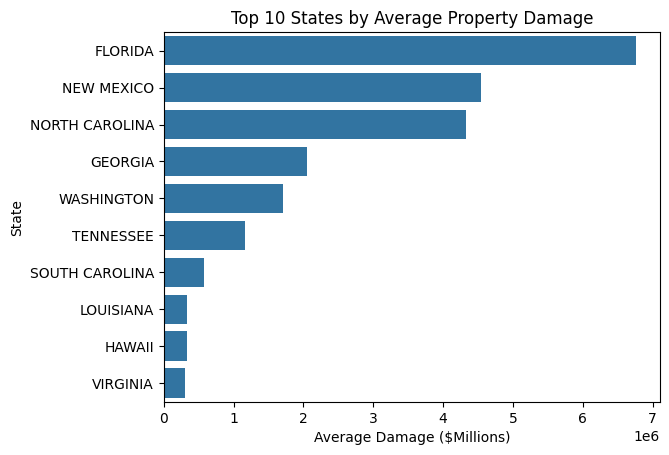

In [ ]:
    # Average damage $ by state type
    damage_by_state = finalset.groupby('STATE')['damage_property_num'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=damage_by_state.values, y=damage_by_state.index)
    plt.title('Top 10 States by Average Property Damage')
    plt.xlabel('Average Damage ($Millions)')
    plt.ylabel('State')
    plt.show()

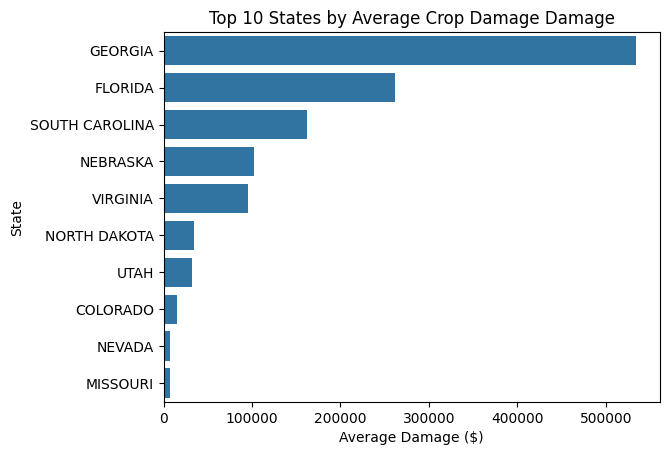

In [ ]:
    # Average damage $ by state type
    damage_by_state = finalset.groupby('STATE')['damage_crops_num'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=damage_by_state.values, y=damage_by_state.index)
    plt.title('Top 10 States by Average Crop Damage Damage')
    plt.xlabel('Average Damage ($)')
    plt.ylabel('State')
    plt.show()

Text(0, 0.5, 'Number of Events')

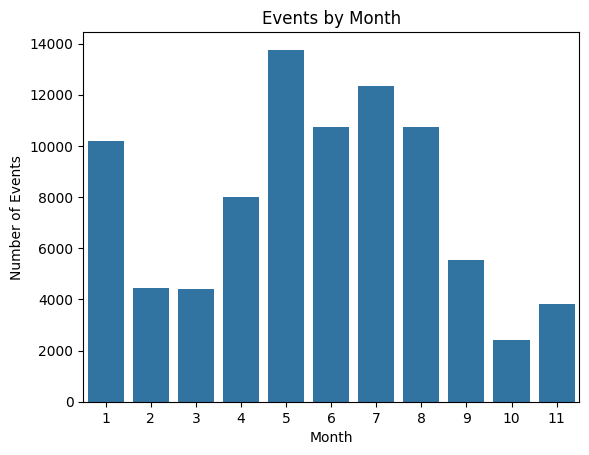

In [ ]:
    # Monthly distribution
    finalset['month'] = finalset['BEGIN_DATE_TIME'].dt.month
    monthly_events = finalset['month'].value_counts().sort_index()
    sns.barplot(x=monthly_events.index, y=monthly_events.values)
    plt.title('Events by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')

Text(0, 0.5, 'Number of Events')

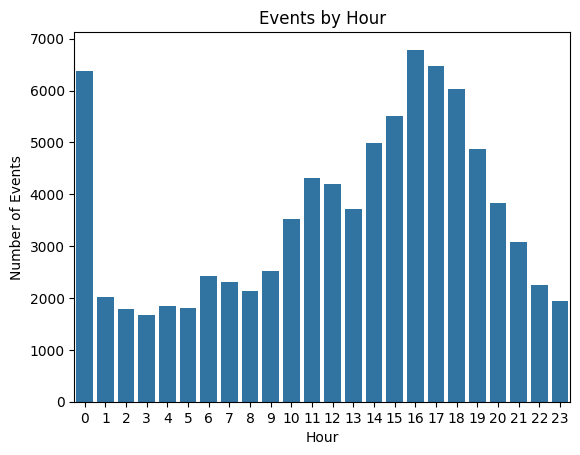

In [ ]:
    finalset['hour'] = finalset['BEGIN_DATE_TIME'].dt.hour
    monthly_events = finalset['hour'].value_counts().sort_index()
    sns.barplot(x=monthly_events.index, y=monthly_events.values)
    plt.title('Events by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Number of Events')

Text(0.5, 1.0, 'Top 15 States by Number of Events')

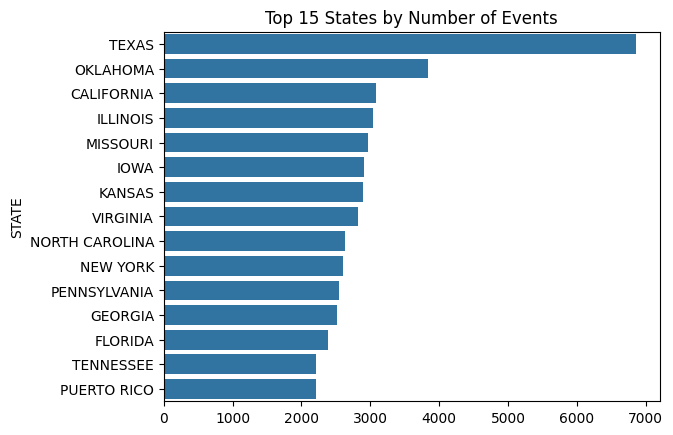

In [ ]:
    state_events = finalset['STATE'].value_counts().sort_values(ascending=False).head(15)
    sns.barplot(x=state_events.values, y=state_events.index)
    plt.title('Top 15 States by Number of Events')

Text(0, 0.5, 'Event Type')

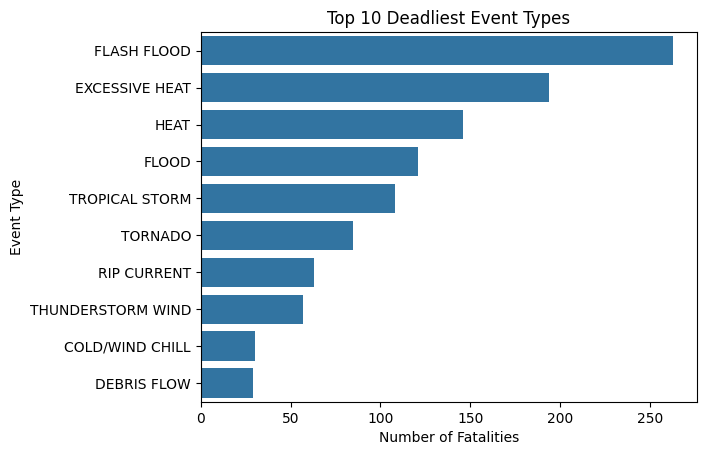

In [ ]:
# Fatalities by event type
fatal_by_type = finalset.groupby('EVENT_TYPE')['FATALITY_ID'].count().sort_values(ascending=False).head(10)
sns.barplot(x=fatal_by_type.values, y=fatal_by_type.index)
plt.title('Top 10 Deadliest Event Types')
plt.xlabel('Number of Fatalities')
plt.ylabel('Event Type')

In [ ]:
traffic_light = LinearSegmentedColormap.from_list("traffic_light", ["#4FF08D", "#F0DB5B", "#ED665C"])


In [ ]:
Top15 = finalset['STATE'].value_counts().head(15).sort_values(ascending=False).index
finalset['month'] = finalset['BEGIN_DATE_TIME'].dt.month
finalset['inmill2']=finalset['damage_property_num']/1000

finalset2 = finalset[finalset['STATE'].isin(Top15)]
table3=pd.crosstab(finalset2['STATE'], finalset2['month'],values=finalset2['inmill2'], margins=True,aggfunc='mean')


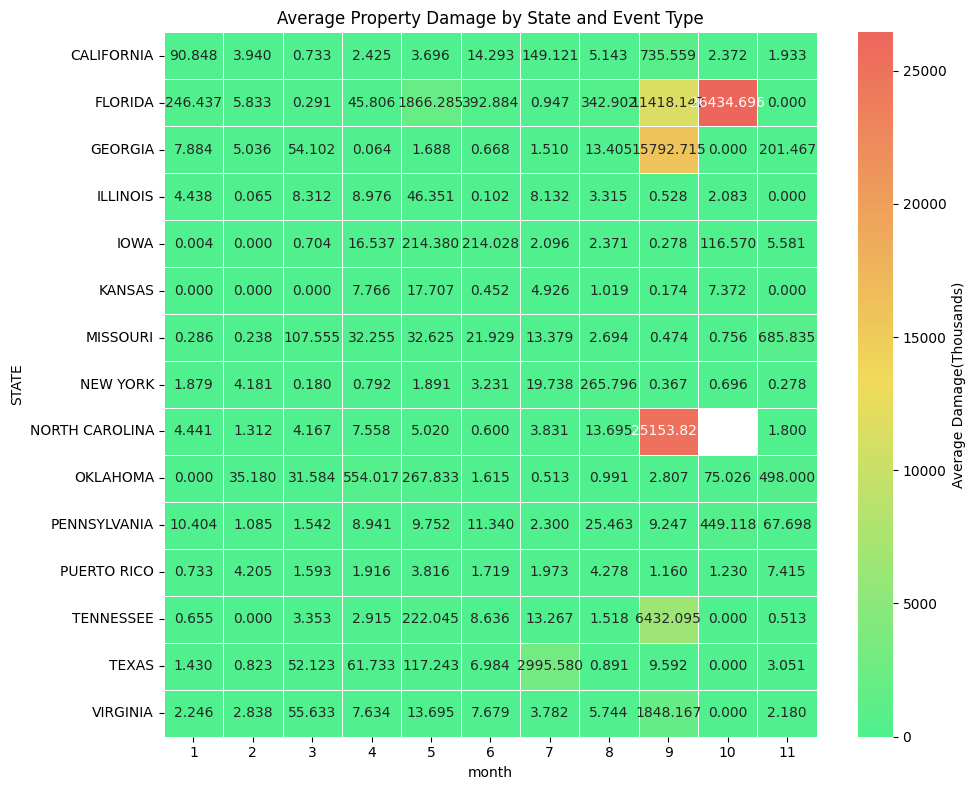

In [ ]:
table3_no_totals = table3.iloc[:-1, :-1]
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(table3_no_totals, annot=True, cmap=traffic_light, fmt=".3f", cbar_kws={'label': 'Average Damage(Thousands)'}, linewidths=0.5)

# Add title and show the plot
plt.title('Average Property Damage by State and Event Type')
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()

In [ ]:
Top15 = finalset['STATE'].value_counts().head(15).sort_values(ascending=False).index
finalset['month'] = finalset['BEGIN_DATE_TIME'].dt.month
finalset['inmill3']=finalset['damage_crops_num']/1000

finalset3 = finalset[finalset['STATE'].isin(Top15)]
table4=pd.crosstab(finalset3['STATE'], finalset3['month'],values=finalset3['inmill3'], margins=True,aggfunc='mean')

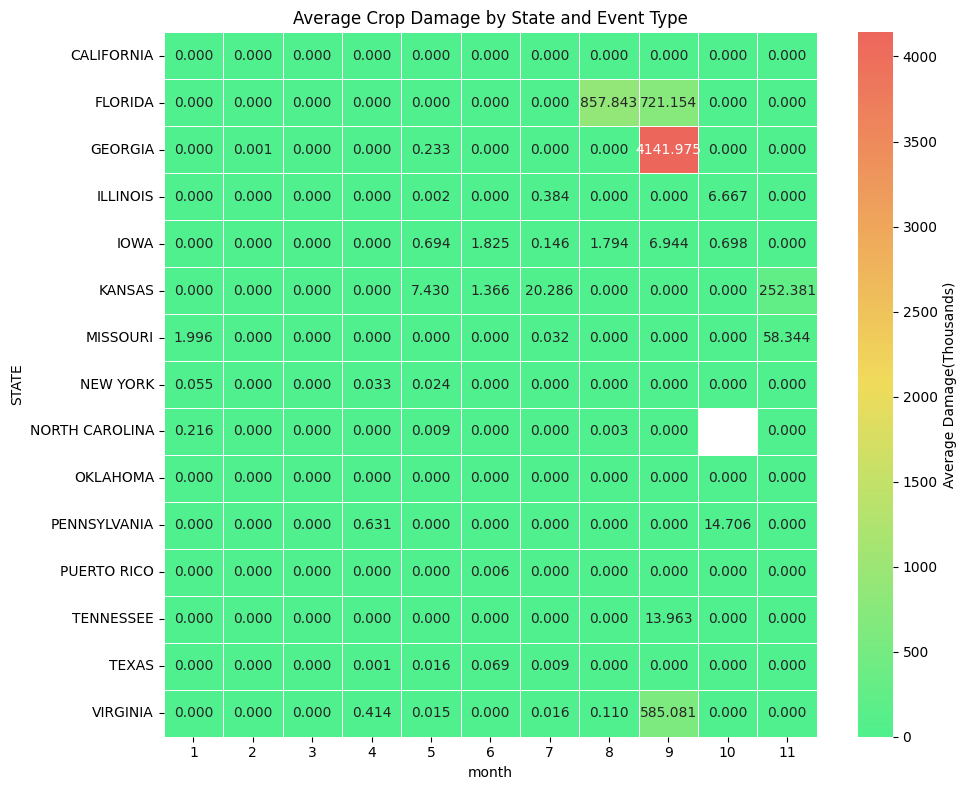

In [ ]:
table4_no_totals = table4.iloc[:-1, :-1]
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(table4_no_totals, annot=True, cmap=traffic_light, fmt=".3f", cbar_kws={'label': 'Average Damage(Thousands)'}, linewidths=0.5)

# Add title and show the plot
plt.title('Average Crop Damage by State and Event Type')
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()

In [ ]:
Top15 = finalset['STATE'].value_counts().head(15).sort_values(ascending=False).index
finalset['month'] = finalset['BEGIN_DATE_TIME'].dt.month
finalset4 = finalset[finalset['STATE'].isin(Top15)]
finalset4['Total_Injuries'] = finalset4['INJURIES_DIRECT'] + finalset4['INJURIES_INDIRECT']
finalset4['Total_Deaths'] = finalset4['DEATHS_DIRECT'] + finalset4['DEATHS_INDIRECT']
table5=pd.crosstab(finalset4['STATE'], finalset4['month'],values=finalset4['Total_Injuries'], margins=True,aggfunc='sum')

<ipython-input-45-26c1c5a90786>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalset4['Total_Injuries'] = finalset4['INJURIES_DIRECT'] + finalset4['INJURIES_INDIRECT']
<ipython-input-45-26c1c5a90786>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalset4['Total_Deaths'] = finalset4['DEATHS_DIRECT'] + finalset4['DEATHS_INDIRECT']


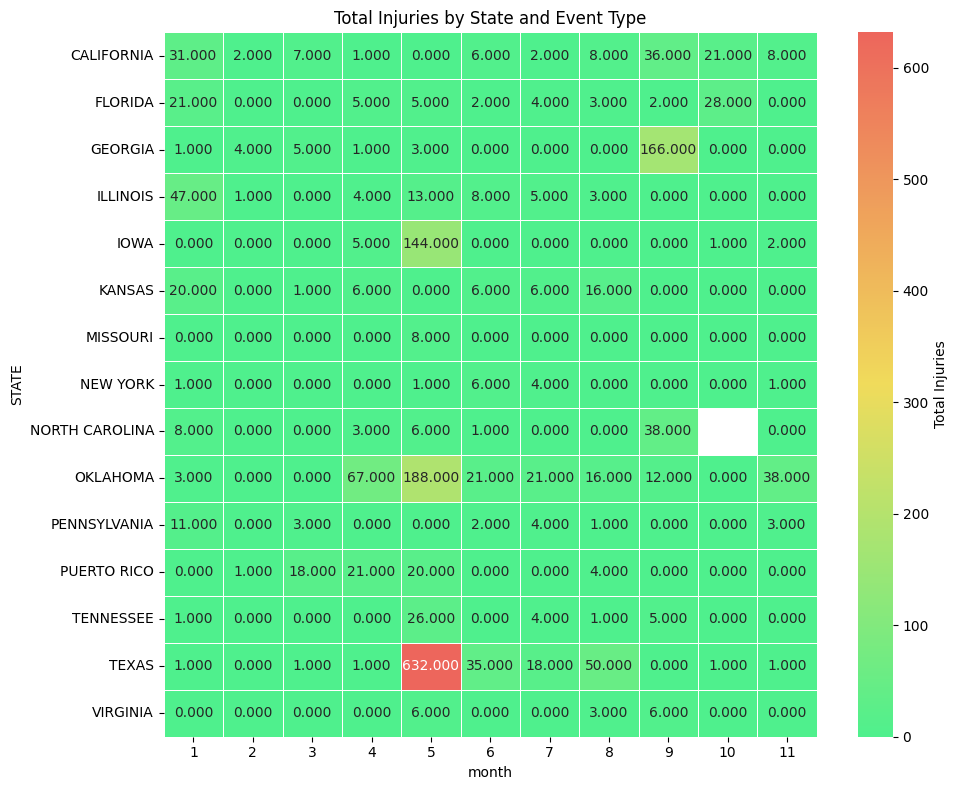

In [ ]:
table5_no_totals = table5.iloc[:-1, :-1]
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(table5_no_totals, annot=True, cmap=traffic_light, fmt=".3f", cbar_kws={'label': 'Total Injuries'}, linewidths=0.5)

# Add title and show the plot
plt.title('Total Injuries by State and Event Type')
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()

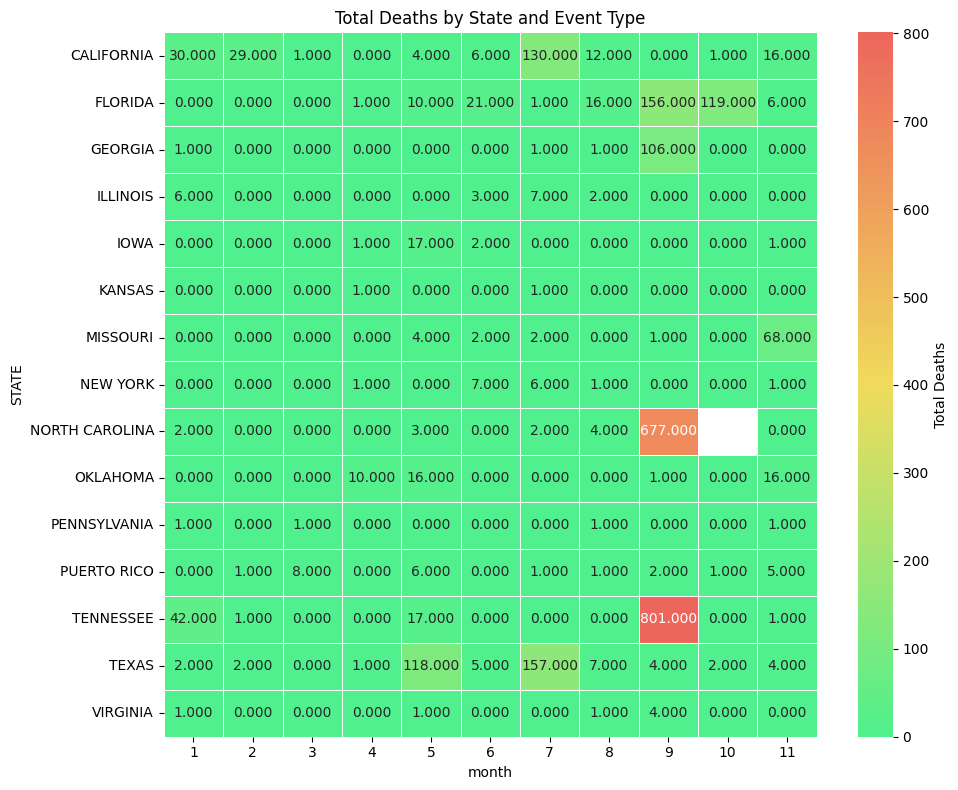

In [ ]:
table6=pd.crosstab(finalset4['STATE'], finalset4['month'],values=finalset4['Total_Deaths'], margins=True,aggfunc='sum')
table6_no_totals = table6.iloc[:-1, :-1]
plt.figure(figsize=(10, 8))  # Adjust size as necessary
sns.heatmap(table6_no_totals, annot=True, cmap=traffic_light, fmt=".3f", cbar_kws={'label': 'Total Deaths'}, linewidths=0.5)

# Add title and show the plot
plt.title('Total Deaths by State and Event Type')
plt.tight_layout()  # Adjust the layout to avoid clipping
plt.show()

Text(0, 0.5, 'Number of Events')

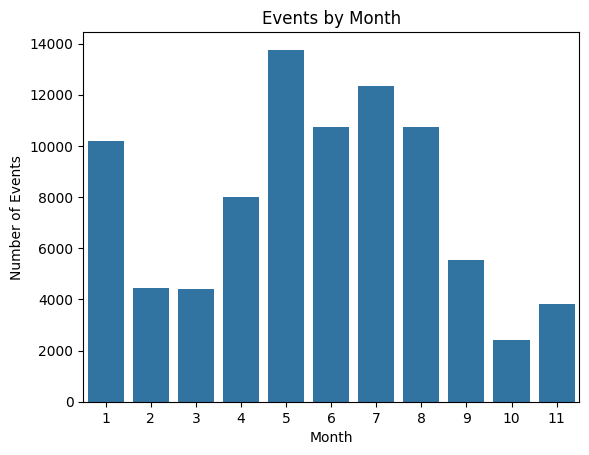

In [ ]:
    finalset['month'] = finalset['BEGIN_DATE_TIME'].dt.month
    monthly_events = finalset['month'].value_counts().sort_index()
    sns.barplot(x=monthly_events.index, y=monthly_events.values)
    plt.title('Events by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')

#HEATMAPS

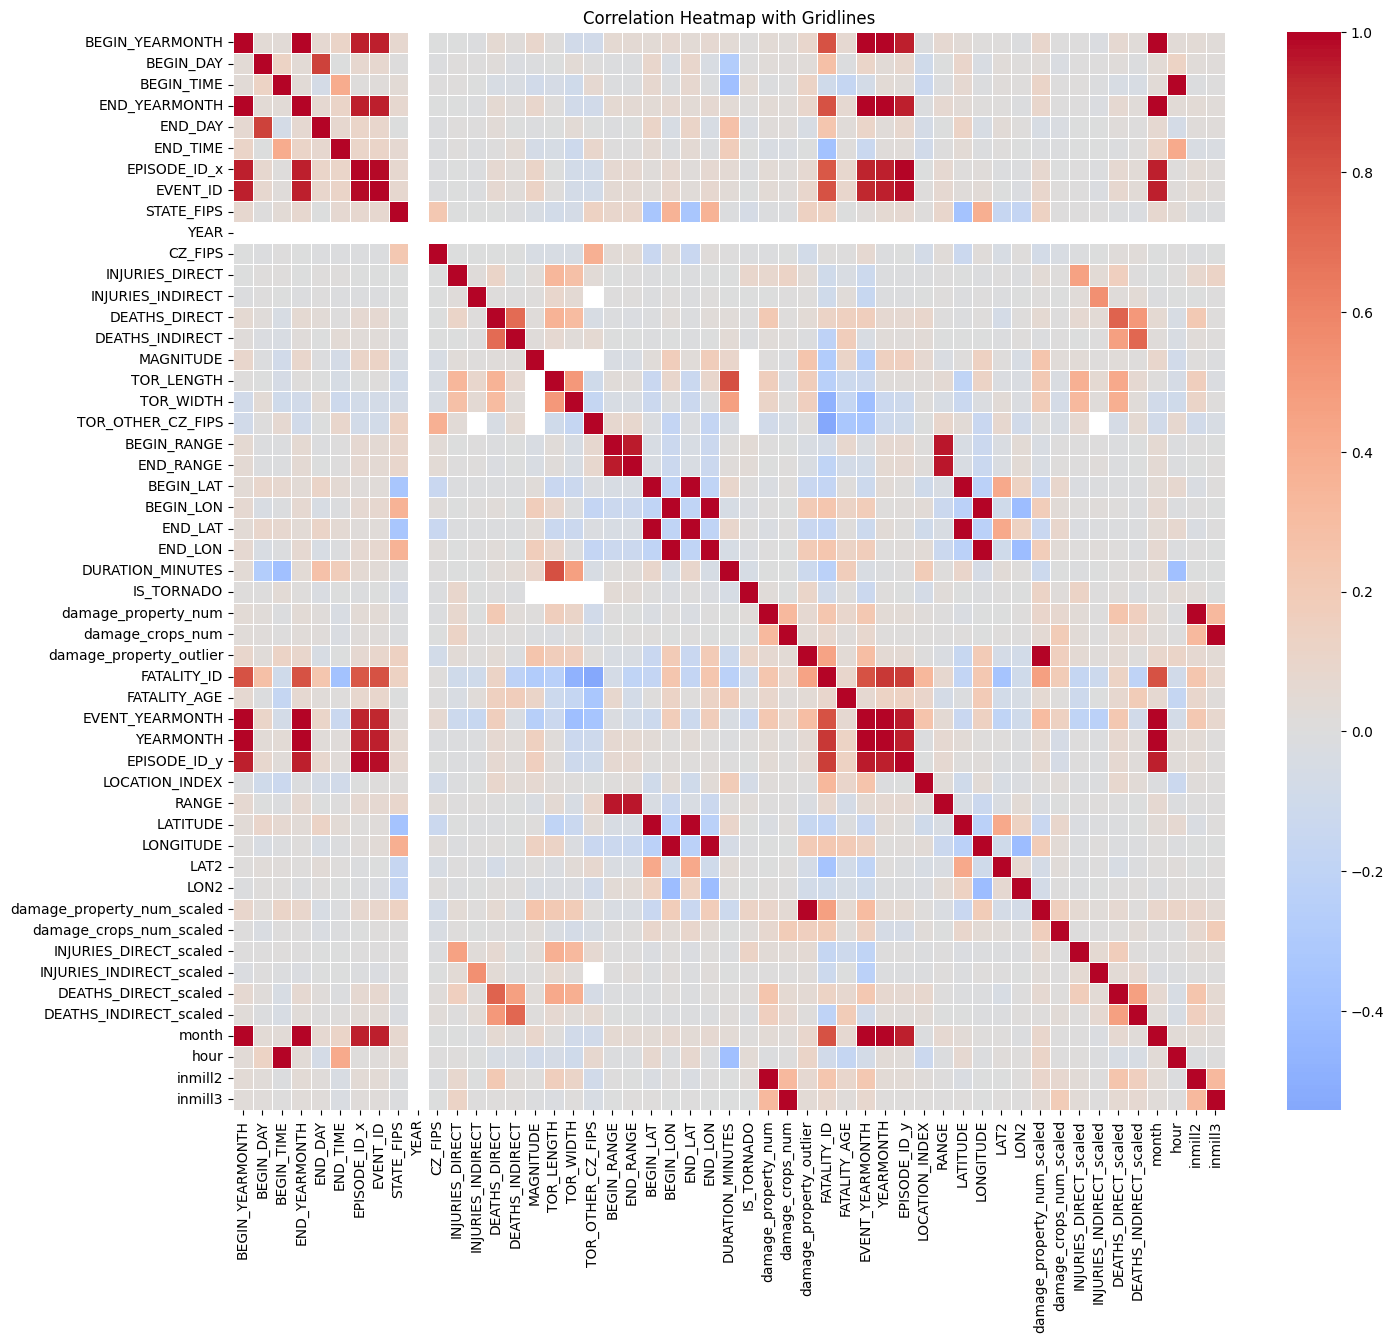

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = finalset.corr(numeric_only=True)

# Plot heatmap with gridlines
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linecolor='white',
    linewidths=0.5
)
plt.title("Correlation Heatmap with Gridlines")
plt.show()


In [ ]:
corr_matrix = finalset.corr(numeric_only=True).abs()

# Find pairs of features with correlation > 0.9 (excluding self-correlation)
high_corr_pairs = corr_matrix.stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > 0.9]

# Extract just the column names to consider dropping (deduplicated)
to_drop = set(high_corr_pairs['level_1'])
to_drop.discard("Impact_Score")


to_drop.discard("Impact_Score_Norm")
to_drop.add("Impact_Score")
print("Highly correlated features to consider dropping:", to_drop)


Highly correlated features to consider dropping: {'damage_property_num_scaled', 'BEGIN_LAT', 'RANGE', 'inmill2', 'YEARMONTH', 'inmill3', 'Impact_Score', 'BEGIN_YEARMONTH', 'month', 'BEGIN_LON', 'BEGIN_TIME', 'END_YEARMONTH', 'END_LON', 'hour', 'EVENT_ID', 'EPISODE_ID_y', 'END_RANGE', 'EPISODE_ID_x', 'LATITUDE', 'damage_crops_num', 'damage_property_num', 'damage_property_outlier', 'EVENT_YEARMONTH', 'END_LAT', 'LONGITUDE', 'BEGIN_RANGE'}


In [ ]:
finalset.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID_x,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,Begin_YearMonth,End_YearMonth,DURATION_MINUTES,IS_TORNADO,last_char,damage_property_num,damage_crops_num,damage_property_outlier,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH,FATALITY_FULL_DATETIME,YEARMONTH,EPISODE_ID_y,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,damage_property_num_scaled,damage_crops_num_scaled,INJURIES_DIRECT_scaled,INJURIES_INDIRECT_scaled,DEATHS_DIRECT_scaled,DEATHS_INDIRECT_scaled,month,hour,inmill2,inmill3
0,202405,23,1947,202405,23,1947,190907,1180619,OKLAHOMA,40,2024,May,HAIL,C,65,JACKSON,OUN,2024-05-23 19:47:00,CST-6,2024-05-23 19:47:00,0,0,0,0,NaN,NaN,Public,1.5,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,S,FRIENDSHIP,4.0,S,FRIENDSHIP,34.6380,-99.2167,34.6380,-99.2167,Two primary rounds of severe convection occurr...,MPing report.,CSV,2024-05-01,2024-05-01,0.0,False,NaN,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5,19,0.0,0.0
1,202411,16,230,202411,18,1421,197838,1223377,OREGON,41,2024,November,HEAVY SNOW,Z,509,EAST SLOPES OF THE OREGON CASCADES,PDT,2024-11-16 02:30:00,PST-8,2024-11-18 14:21:00,0,0,0,0,0.00K,0.00K,SNOTEL,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A series of cold fronts the weekend of Nov. 16...,The Hog Pass SNOTEL reported an estimated 12 i...,CSV,2024-11-01,2024-11-01,3591.0,False,K,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,11,2,0.0,0.0
2,202405,19,1839,202405,19,1902,190905,1184919,OKLAHOMA,40,2024,May,TORNADO,C,39,CUSTER,OUN,2024-05-19 18:39:00,CST-6,2024-05-19 19:02:00,0,0,0,0,150.00K,0.00K,NWS Storm Survey,NaN,N/A,N/A,N/A,EF1,6.7,400.0,NaN,NaN,NaN,NaN,8.0,WNW,CUSTER CITY,5.0,N,CUSTER CITY,35.7100,-99.0010,35.7370,-98.8910,Significant severe weather occurred across por...,While the large multiple-vortex tornado was ap...,CSV,2024-05-01,2024-05-01,23.0,True,K,150000.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.926403,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5,18,150.0,0.0
3,202405,23,2155,202405,23,2155,190907,1180805,OKLAHOMA,40,2024,May,THUNDERSTORM WIND,C,51,GRADY,OUN,2024-05-23 21:55:00,CST-6,2024-05-23 21:55:00,0,0,0,0,10.00K,NaN,Other Federal Agency,61.0,EG,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,W,NINNEKAH,2.0,W,NINNEKAH,34.9501,-97.9523,34.9501,-97.9523,Two primary rounds of severe convection occurr...,Relayed image showing a portable outbuilding b...,CSV,2024-05-01,2024-05-01,0.0,False,K,10000.0,0.0,True,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.343287,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,5,21,10.0,0.0
4,202411,22,400,202411,22,1100,197326,1220680,NEW YORK,36,2024,November,WINTER WEATHER,Z,67,ORANGE,OKX,2024-11-22 04:00:00,EST-5,2024-11-22 11:00:00,0,0,0,0,0.00K,0.00K,Trained Spotter,NaN,N/A,N/A,N/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An occluded low pressure system brought heavy ...,A trained spotter reported 10.0 inches of wet ...,CSV,2024-11-01,2024-11-01,420.0,False,K,0.0,0.0,False,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,Na

#Clustering

In [ ]:
X = finalset[['damage_property_num','damage_crops_num','INJURIES_DIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_INDIRECT','EVENT_TYPE']]

In [ ]:
X['Total_Damage'] = X['damage_property_num'] + X['damage_crops_num']
X['Log_Total_Damage'] = np.log1p(X['Total_Damage'])

X['Total_Injuries'] = X['INJURIES_DIRECT'] + X['INJURIES_INDIRECT']
X['Total_Deaths'] = X['DEATHS_DIRECT'] + X['DEATHS_INDIRECT']
X['Total_Casualties'] = X['Total_Injuries'] + X['Total_Deaths']

VSL= 13.2
VSLI=VSL*.50

X['Severity_Score'] = (X['Total_Deaths'] * VSL +
                             X['Total_Injuries'] * VSLI +
                             np.log1p(X['Total_Damage']))
le_event = LabelEncoder()
X['Event_encoded'] = le_event.fit_transform(X['EVENT_TYPE'])
X = X[X['Severity_Score'] != 0]

X=X.drop(['damage_property_num','damage_crops_num','INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','Total_Injuries','Total_Deaths','Total_Damage','EVENT_TYPE'],axis=1)

<ipython-input-53-9fb0dc4f4224>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Total_Damage'] = X['damage_property_num'] + X['damage_crops_num']
<ipython-input-53-9fb0dc4f4224>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Log_Total_Damage'] = np.log1p(X['Total_Damage'])
<ipython-input-53-9fb0dc4f4224>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

NameError: name 'LabelEncoder' is not defined

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
df=pd.DataFrame()
df['Cluster'] = labels
df['Cluster'].value_counts()


In [ ]:
X.info()

In [ ]:
import matplotlib.pyplot as plt

# Assume X is your data and labels are from KMeans
plt.scatter(X['Total_Casualties'], X['Severity_Score'], c=labels, cmap='viridis', s=50)

plt.title("K-Means Clustering")
plt.xlabel("Total Casualties")
plt.ylabel("Severity Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.scatter(X['Log_Total_Damage'], X['Severity_Score'], c=labels, cmap='viridis', s=50)

plt.title("K-Means Clustering")
plt.xlabel("Total Damage")
plt.ylabel("Severity Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, labels)
print("Silhouette Score:", score)


In [ ]:
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

    X['kaemclusterid'] = labels

    features = X.drop(columns='kaemclusterid')
    target=X['kaemclusterid']

    qda = QuadraticDiscriminantAnalysis()
    qda.fit(features,target)
    posterior_probs = qda.predict_proba(features)
    probs_df = pd.DataFrame(posterior_probs, columns=[f"P(Class {c})" for c in qda.classes_])
    probs_df = probs_df.applymap(lambda x: f"{x:.2e}")
    probs_df['predicted_class'] = qda.predict(features)
    probs_df['true_class'] = target
    probs_df['review']=np.where(probs_df['predicted_class'] == probs_df['true_class'], 'Well Clustered', 'Not Well Clustered')
    pivot = pd.crosstab(probs_df['true_class'], probs_df['review'])

    pivot_percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

    piv=pivot_percent = pivot_percent.round(2)
    print((probs_df['review'] == 'Not Well Clustered').sum() / len(probs_df))
    X.drop(columns='kaemclusterid',inplace=True)
    piv


# STATE MAPPING

Mapped the states to their Region Divisions

In [ ]:
df_copy = finalset[['EVENT_ID','MONTH_NAME', 'EVENT_TYPE', 'STATE', 'damage_property_num', 'INJURIES_DIRECT',
                    'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'damage_crops_num','DURATION_MINUTES']].copy()


In [ ]:
import geopandas as gpd
from shapely.geometry import Point


In [ ]:
regions = gpd.read_file("/content/drive/MyDrive/Data_Files/cb_2020_us_division_500k.shp")

In [ ]:
locs = locations.copy()

In [ ]:
locs['geometry'] = locs.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)

In [ ]:
locs_gdf = gpd.GeoDataFrame(locs, geometry='geometry', crs="EPSG:4326")

In [ ]:
locs_gdf = locs_gdf.to_crs("EPSG:4326")
regions = regions.to_crs("EPSG:4326")

In [ ]:
locs_with_region = gpd.sjoin(locs_gdf, regions, how='left', predicate='intersects')

In [ ]:
locs_with_region.head()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2,geometry,index_right,DIVISIONCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER
0,202404,188809,1161227,1,0.90,SW,HAPPY TOWN,33.9900,-81.090,3359400,815400,POINT (-81.09 33.99),0.0,5,0300000US5,5,South Atlantic,South Atlantic Division,69,6.871253e+11,8.633960e+10
1,202404,188809,1161228,1,0.00,N,COLUMBIA,34.0000,-81.020,3400,811200,POINT (-81.02 34),0.0,5,0300000US5,5,South Atlantic,South Atlantic Division,69,6.871253e+11,8.633960e+10
2,202404,188809,1161229,1,0.57,E,COLUMBIA,34.0000,-81.010,3400,81600,POINT (-81.01 34),0.0,5,0300000US5,5,South Atlantic,South Atlantic Division,69,6.871253e+11,8.633960e+10
3,202404,188809,1161230,1,0.96,S,BALLTOWN,33.5661,-81.730,3333966,8143800,POINT (-81.73 33.5661),0.0,5,0300000US5,5,South Atlantic,South Atlantic Division,69,6.871253e+11,8.633960e+10
4,202404,188809,1161231,1,0.62,N,COLUMBIA,34.0090,-81.021,34540,811260,POINT (-81.021 34.009),0.0,5,0300000US5,5,South Atlantic,South Atlantic Division,69,6.871253e+11,8.633960e+10


In [ ]:
region_lookup = locs_with_region[['EVENT_ID', 'NAME']].drop_duplicates()

In [ ]:
matched_ids = df_copy['EVENT_ID'].isin(region_lookup['EVENT_ID'])
print(f"Matches found: {matched_ids.sum()} out of {len(df_copy)}")


Matches found: 47817 out of 86410


In [ ]:
df_copy = pd.merge(df_copy, region_lookup, on='EVENT_ID', how='left')

In [ ]:
df_copy.rename(columns={'NAME': 'Region'}, inplace=True)

In [ ]:
df_copy.drop(columns=['NAME_x', 'NAME_y'], errors='ignore', inplace=True)

In [ ]:
df_copy = df_copy.loc[:, ~df_copy.columns.duplicated()]


In [ ]:
unmatched = df_copy[df_copy['Region'].isna()]
print(f"Unmatched entries: {len(unmatched)}")
print(unmatched[['EVENT_ID']].head())


Unmatched entries: 42015
   EVENT_ID
0   1180619
1   1223377
2   1184919
3   1180805
4   1220680


In [ ]:
state_to_division = {
    # Division 1: New England
    'CONNECTICUT': 'New England',
    'MAINE': 'New England',
    'MASSACHUSETTS': 'New England',
    'NEW HAMPSHIRE': 'New England',
    'RHODE ISLAND': 'New England',
    'VERMONT': 'New England',

    # Division 2: Middle Atlantic
    'NEW JERSEY': 'Middle Atlantic',
    'NEW YORK': 'Middle Atlantic',
    'PENNSYLVANIA': 'Middle Atlantic',

    # Division 3: East North Central
    'ILLINOIS': 'East North Central',
    'INDIANA': 'East North Central',
    'MICHIGAN': 'East North Central',
    'OHIO': 'East North Central',
    'WISCONSIN': 'East North Central',

    # Division 4: West North Central
    'IOWA': 'West North Central',
    'KANSAS': 'West North Central',
    'MINNESOTA': 'West North Central',
    'MISSOURI': 'West North Central',
    'NEBRASKA': 'West North Central',
    'NORTH DAKOTA': 'West North Central',
    'SOUTH DAKOTA': 'West North Central',

    # Division 5: South Atlantic
    'DELAWARE': 'South Atlantic',
    'DISTRICT OF COLUMBIA': 'South Atlantic',
    'FLORIDA': 'South Atlantic',
    'GEORGIA': 'South Atlantic',
    'MARYLAND': 'South Atlantic',
    'NORTH CAROLINA': 'South Atlantic',
    'SOUTH CAROLINA': 'South Atlantic',
    'VIRGINIA': 'South Atlantic',
    'WEST VIRGINIA': 'South Atlantic',

    # Division 6: East South Central
    'ALABAMA': 'East South Central',
    'KENTUCKY': 'East South Central',
    'MISSISSIPPI': 'East South Central',
    'TENNESSEE': 'East South Central',

    # Division 7: West South Central
    'ARKANSAS': 'West South Central',
    'LOUISIANA': 'West South Central',
    'OKLAHOMA': 'West South Central',
    'TEXAS': 'West South Central',

    # Division 8: Mountain
    'ARIZONA': 'Mountain',
    'COLORADO': 'Mountain',
    'IDAHO': 'Mountain',
    'MONTANA': 'Mountain',
    'NEVADA': 'Mountain',
    'NEW MEXICO': 'Mountain',
    'UTAH': 'Mountain',
    'WYOMING': 'Mountain',

    # Division 9: Pacific
    'ALASKA': 'Pacific',
    'CALIFORNIA': 'Pacific',
    'HAWAII': 'Pacific',
    'OREGON': 'Pacific',
    'WASHINGTON': 'Pacific',
}

In [ ]:
df_copy['Region'] = df_copy.apply(
    lambda row: state_to_division.get(row['STATE']) if pd.isna(row['Region']) else row['Region'],
    axis=1
)

In [ ]:
print("Still unmatched:", df_copy['Region'].isna().sum())

Still unmatched: 4025


In [ ]:
unmatched_states = df_copy[df_copy['Region'].isna()]['STATE'].unique()
print("Unmatched STATE values:", unmatched_states)

Unmatched STATE values: ['GULF OF MEXICO' 'LAKE MICHIGAN' 'AMERICAN SAMOA' 'ATLANTIC SOUTH'
 'E PACIFIC' 'ATLANTIC NORTH' 'VIRGIN ISLANDS' 'PUERTO RICO'
 'LAKE SUPERIOR' 'GUAM' 'LAKE ERIE' 'LAKE HURON' 'LAKE ST CLAIR'
 'LAKE ONTARIO' 'GUAM WATERS' 'GULF OF ALASKA']


In [ ]:
df_copy['Region'] = df_copy['STATE'].apply(
    lambda s: state_to_division.get(s, s)
)

In [ ]:
print("Still unmatched:", df_copy['Region'].isna().sum())

Still unmatched: 0


In [ ]:
df_copy.head()

,EVENT_ID,MONTH_NAME,EVENT_TYPE,STATE,damage_property_num,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,damage_crops_num,DURATION_MINUTES,Region
0,1180619,May,HAIL,OKLAHOMA,0.0,0,0,0,0,0.0,0.0,West South Central
1,1223377,November,HEAVY SNOW,OREGON,0.0,0,0,0,0,0.0,3591.0,Pacific
2,1184919,May,TORNADO,OKLAHOMA,150000.0,0,0,0,0,0.0,23.0,West South Central
3,1180805,May,THUNDERSTORM WIND,OKLAHOMA,10000.0,0,0,0,0,0.0,0.0,West South Central
4,1220680,November,WINTER WEATHER,NEW YORK,0.0,0,0,0,0,0.0,420.0,Middle Atlantic


In [ ]:
season_map = {
    'January': 'Winter', 'February': 'Winter', 'December': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}
df_copy['Season'] = df_copy['MONTH_NAME'].map(season_map)

In [ ]:

df_copy['Total_Damage'] = df_copy['damage_property_num'] + df_copy['damage_crops_num']
df_copy['Log_Total_Damage'] = np.log1p(df_copy['Total_Damage'])

df_copy['Total_Injuries'] = df_copy['INJURIES_DIRECT'] + df_copy['INJURIES_INDIRECT']
df_copy['Total_Deaths'] = df_copy['DEATHS_DIRECT'] + df_copy['DEATHS_INDIRECT']
df_copy['Total_Casualties'] = df_copy['Total_Injuries'] + df_copy['Total_Deaths']

VSL= 13.1
VSLI=VSL*.50

df_copy['Severity_Score'] = (df_copy['Total_Deaths'] * VSL +
                             df_copy['Total_Injuries'] * VSLI +
                             np.log1p(df_copy['Total_Damage']))

def severity_category(score):
    if score == 0:
        return 'None'
    elif score < 75:
        return 'Low'
    elif score < 300:
        return 'Medium'
    else:
        return 'High'

df_copy['Severity_Category'] = df_copy['Severity_Score'].apply(severity_category)

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le_event = LabelEncoder()
le_state = LabelEncoder()
le_season = LabelEncoder()
le_region = LabelEncoder()
le_severity = LabelEncoder()

df_copy['Event_encoded'] = le_event.fit_transform(df_copy['EVENT_TYPE'])
df_copy['State_encoded'] = le_state.fit_transform(df_copy['STATE'])
df_copy['Season_encoded'] = le_season.fit_transform(df_copy['Season'])
df_copy['Region_encoded'] = le_region.fit_transform(df_copy['Region'])
df_copy['Severity_encoded'] = le_severity.fit_transform(df_copy['Severity_Category'])

df_encoded = df_copy.copy()
cat_features = ['EVENT_TYPE', 'Season', 'Region']
df_encoded = pd.get_dummies(df_copy, columns=cat_features, drop_first=False)

In [ ]:
df_copy.head()

,EVENT_ID,MONTH_NAME,EVENT_TYPE,STATE,damage_property_num,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,damage_crops_num,DURATION_MINUTES,Region,Season,Total_Damage,Log_Total_Damage,Total_Injuries,Total_Deaths,Total_Casualties,Severity_Score,Severity_Category,Event_encoded,State_encoded,Season_encoded,Region_encoded,Severity_encoded
0,1180619,May,HAIL,OKLAHOMA,0.0,0,0,0,0,0.0,0.0,West South Central,Spring,0.0,0.000000,0,0,0,0.000000,None,17,50,1,25,3
1,1223377,November,HEAVY SNOW,OREGON,0.0,0,0,0,0,0.0,3591.0,Pacific,Fall,0.0,0.000000,0,0,0,0.000000,None,20,51,0,20,3
2,1184919,May,TORNADO,OKLAHOMA,150000.0,0,0,0,0,0.0,23.0,West South Central,Spring,150000.0,11.918397,0,0,0,11.918397,Low,43,50,1,25,1
3,1180805,May,THUNDERSTORM WIND,OKLAHOMA,10000.0,0,0,0,0,0.0,0.0,West South Central,Spring,10000.0,9.210440,0,0,0,9.210440,Low,42,50,1,25,1
4,1220680,November,WINTER WEATHER,NEW YORK,0.0,0,0,0,0,0.0,420.0,Middle Atlantic,Fall,0.0,0.000000,0,0,0,0.000000,None,49,46,0,16,3


In [ ]:
print("All columns in the dataset:")
for col in df_encoded.columns:
    print(f"- {col}")

print(f"\nTotal columns: {len(df_encoded.columns)}")

All columns in the dataset:
- EVENT_ID
- MONTH_NAME
- STATE
- damage_property_num
- INJURIES_DIRECT
- INJURIES_INDIRECT
- DEATHS_DIRECT
- DEATHS_INDIRECT
- damage_crops_num
- DURATION_MINUTES
- Total_Damage
- Log_Total_Damage
- Total_Injuries
- Total_Deaths
- Total_Casualties
- Severity_Score
- Severity_Category
- Event_encoded
- State_encoded
- Season_encoded
- Region_encoded
- Severity_encoded
- EVENT_TYPE_ASTRONOMICAL LOW TIDE
- EVENT_TYPE_AVALANCHE
- EVENT_TYPE_BLIZZARD
- EVENT_TYPE_COASTAL FLOOD
- EVENT_TYPE_COLD/WIND CHILL
- EVENT_TYPE_DEBRIS FLOW
- EVENT_TYPE_DENSE FOG
- EVENT_TYPE_DROUGHT
- EVENT_TYPE_DUST DEVIL
- EVENT_TYPE_DUST STORM
- EVENT_TYPE_EXCESSIVE HEAT
- EVENT_TYPE_EXTREME COLD/WIND CHILL
- EVENT_TYPE_FLASH FLOOD
- EVENT_TYPE_FLOOD
- EVENT_TYPE_FREEZING FOG
- EVENT_TYPE_FROST/FREEZE
- EVENT_TYPE_FUNNEL CLOUD
- EVENT_TYPE_HAIL
- EVENT_TYPE_HEAT
- EVENT_TYPE_HEAVY RAIN
- EVENT_TYPE_HEAVY SNOW
- EVENT_TYPE_HIGH SURF
- EVENT_TYPE_HIGH WIND
- EVENT_TYPE_HURRICANE
- EVENT_

# Random Forest (Regression)

Predicting Log_Total_Damage



In [ ]:
y_reg = df_encoded['Log_Total_Damage']

In [ ]:
print("All columns in the dataset:")
for col in df_encoded.columns:
    print(f"- {col}")

print(f"\nTotal columns: {len(df_encoded.columns)}")

All columns in the dataset:
- EVENT_ID
- MONTH_NAME
- STATE
- damage_property_num
- INJURIES_DIRECT
- INJURIES_INDIRECT
- DEATHS_DIRECT
- DEATHS_INDIRECT
- damage_crops_num
- DURATION_MINUTES
- Total_Damage
- Log_Total_Damage
- Total_Injuries
- Total_Deaths
- Total_Casualties
- Severity_Score
- Severity_Category
- Event_encoded
- State_encoded
- Season_encoded
- Region_encoded
- Severity_encoded
- EVENT_TYPE_ASTRONOMICAL LOW TIDE
- EVENT_TYPE_AVALANCHE
- EVENT_TYPE_BLIZZARD
- EVENT_TYPE_COASTAL FLOOD
- EVENT_TYPE_COLD/WIND CHILL
- EVENT_TYPE_DEBRIS FLOW
- EVENT_TYPE_DENSE FOG
- EVENT_TYPE_DROUGHT
- EVENT_TYPE_DUST DEVIL
- EVENT_TYPE_DUST STORM
- EVENT_TYPE_EXCESSIVE HEAT
- EVENT_TYPE_EXTREME COLD/WIND CHILL
- EVENT_TYPE_FLASH FLOOD
- EVENT_TYPE_FLOOD
- EVENT_TYPE_FREEZING FOG
- EVENT_TYPE_FROST/FREEZE
- EVENT_TYPE_FUNNEL CLOUD
- EVENT_TYPE_HAIL
- EVENT_TYPE_HEAT
- EVENT_TYPE_HEAVY RAIN
- EVENT_TYPE_HEAVY SNOW
- EVENT_TYPE_HIGH SURF
- EVENT_TYPE_HIGH WIND
- EVENT_TYPE_HURRICANE
- EVENT_

In [ ]:
drop_regression = [
    'EVENT_ID',
    'STATE',
    'MONTH_NAME',
    'damage_property_num',
    'damage_crops_num',
    'Log_Total_Damage',
    'Total_Damage',
    'Severity_Score',
    'Severity_Category',
    'Severity_encoded',
    'Event_encoded',
    'State_encoded',
    'Season_encoded',
    'Region_encoded'
]

In [ ]:
from sklearn.utils import resample

nonzero_df = df_encoded[df_encoded['Total_Damage'] > 0]
zero_df = df_encoded[df_encoded['Total_Damage'] == 0]

zero_downsampled = resample(
    zero_df,
    replace=False,
    n_samples=min(len(nonzero_df)*2, len(zero_df)),
    random_state=42
)

df_balanced = pd.concat([nonzero_df, zero_downsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
X_reg = df_balanced.drop(columns=drop_regression)
y_reg = df_balanced['Log_Total_Damage']

In [ ]:
print(X_reg.columns)

Index(['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DURATION_MINUTES', 'Total_Injuries', 'Total_Deaths',
       'Total_Casualties', 'EVENT_TYPE_ASTRONOMICAL LOW TIDE',
       'EVENT_TYPE_AVALANCHE', 'EVENT_TYPE_BLIZZARD',
       'EVENT_TYPE_COASTAL FLOOD', 'EVENT_TYPE_COLD/WIND CHILL',
       'EVENT_TYPE_DEBRIS FLOW', 'EVENT_TYPE_DENSE FOG', 'EVENT_TYPE_DROUGHT',
       'EVENT_TYPE_DUST DEVIL', 'EVENT_TYPE_DUST STORM',
       'EVENT_TYPE_EXCESSIVE HEAT', 'EVENT_TYPE_EXTREME COLD/WIND CHILL',
       'EVENT_TYPE_FLASH FLOOD', 'EVENT_TYPE_FLOOD', 'EVENT_TYPE_FREEZING FOG',
       'EVENT_TYPE_FROST/FREEZE', 'EVENT_TYPE_FUNNEL CLOUD', 'EVENT_TYPE_HAIL',
       'EVENT_TYPE_HEAT', 'EVENT_TYPE_HEAVY RAIN', 'EVENT_TYPE_HEAVY SNOW',
       'EVENT_TYPE_HIGH SURF', 'EVENT_TYPE_HIGH WIND', 'EVENT_TYPE_HURRICANE',
       'EVENT_TYPE_ICE STORM', 'EVENT_TYPE_LAKE-EFFECT SNOW',
       'EVENT_TYPE_LAKESHORE FLOOD', 'EVENT_TYPE_LIGHTNING',
       'EVENT_TYPE_MARINE 

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import numpy as np
from imblearn.over_sampling import RandomOverSampler

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_r, y_train_r)

y_pred_r = rf_reg.predict(X_test_r)
rmse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 9.8964
R² Score: 0.5125


*   exp(9.93) ≈ $20,500 average error

*  51% of the variance in storm total damage is captured by the model

Back to dollars

In [ ]:
y_pred_log = rf_reg.predict(X_test_r)

In [ ]:
y_pred_dollars = np.expm1(y_pred_log)
y_actual_dollars = np.expm1(y_test_r)

In [ ]:
comparison_df = pd.DataFrame({
    'Actual ($)': y_actual_dollars,
    'Predicted ($)': y_pred_dollars
})

print(comparison_df.head(10))

       Actual ($)  Predicted ($)
27971      2000.0    1198.524897
46138         0.0       0.000000
36896         0.0       0.000000
3003          0.0       6.715910
56247      7500.0     202.334820
32996      5000.0    5860.477706
54378         0.0      20.370778
56126         0.0       0.000000
2338        500.0     194.520197
44812      1000.0     484.508963


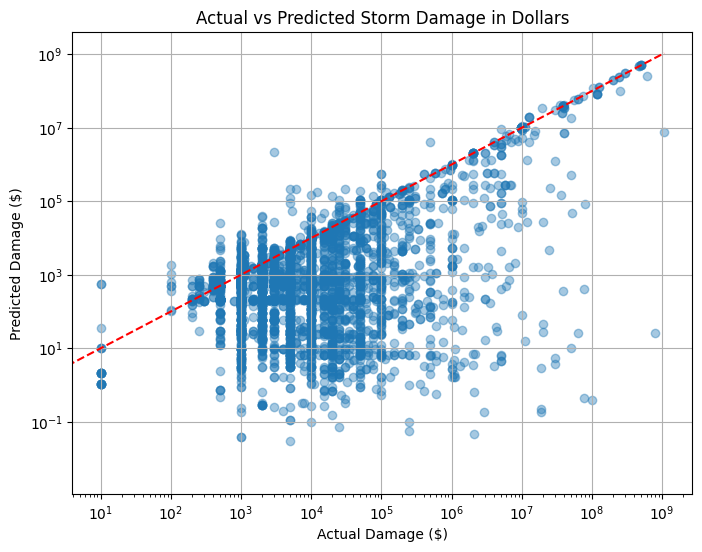

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_actual_dollars, y_pred_dollars, alpha=0.4)
plt.plot([y_actual_dollars.min(), y_actual_dollars.max()],
         [y_actual_dollars.min(), y_actual_dollars.max()], '--r')
plt.xlabel("Actual Damage ($)")
plt.ylabel("Predicted Damage ($)")
plt.title("Actual vs Predicted Storm Damage in Dollars")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

Top 10 features most correlated with Log_Total_Damage:
EVENT_TYPE_THUNDERSTORM WIND    0.203445
Region_PUERTO RICO              0.164221
EVENT_TYPE_TORNADO              0.154667
Season_Winter                   0.115230
EVENT_TYPE_FLASH FLOOD          0.115214
EVENT_TYPE_HAIL                 0.112863
Region_West North Central       0.110023
Region_South Atlantic           0.104348
EVENT_TYPE_HEAT                 0.103972
DURATION_MINUTES                0.101679
Name: Log_Total_Damage, dtype: float64


<ipython-input-94-316b20bdd3c6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


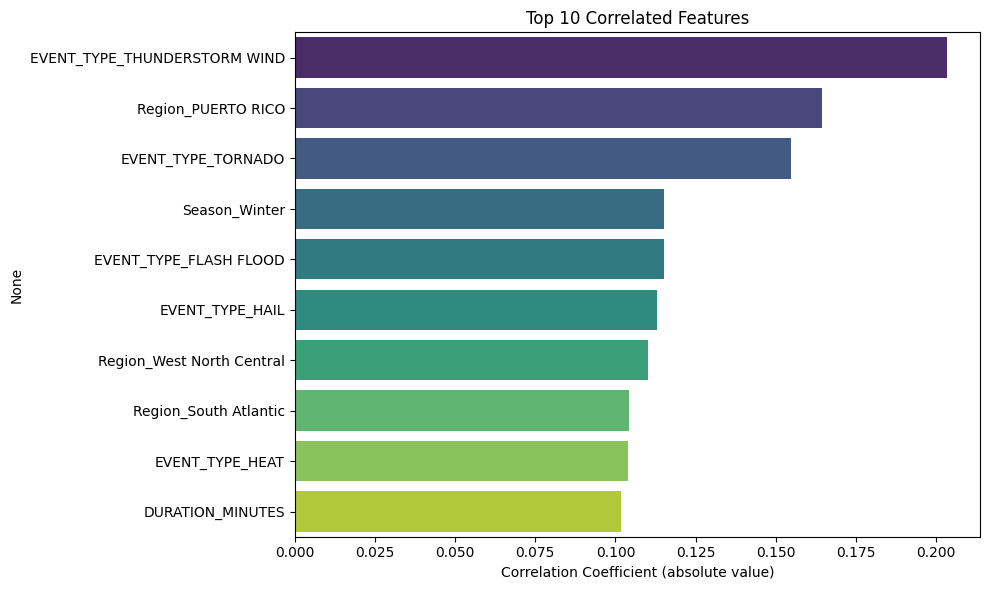

In [ ]:
regression_input = df_encoded.drop(columns=drop_regression)

corr_matrix = regression_input.copy()
corr_matrix['Log_Total_Damage'] = df_encoded['Log_Total_Damage']

target_corr = corr_matrix.corr(numeric_only=True)['Log_Total_Damage'].drop('Log_Total_Damage')
top_corr = target_corr.abs().sort_values(ascending=False).head(10)

print("Top 10 features most correlated with Log_Total_Damage:")
print(top_corr)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title("Top 10 Correlated Features")
plt.xlabel("Correlation Coefficient (absolute value)")
plt.tight_layout()
plt.show()

# Random Forest (Classification)

Predicting Severity Category

Target: severity_encoded

In [ ]:
df_encoded.head()

,EVENT_ID,MONTH_NAME,STATE,damage_property_num,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,damage_crops_num,DURATION_MINUTES,Total_Damage,Log_Total_Damage,Total_Injuries,Total_Deaths,Total_Casualties,Severity_Score,Severity_Category,Event_encoded,State_encoded,Season_encoded,Region_encoded,Severity_encoded,EVENT_TYPE_ASTRONOMICAL LOW TIDE,EVENT_TYPE_AVALANCHE,EVENT_TYPE_BLIZZARD,EVENT_TYPE_COASTAL FLOOD,EVENT_TYPE_COLD/WIND CHILL,EVENT_TYPE_DEBRIS FLOW,EVENT_TYPE_DENSE FOG,EVENT_TYPE_DROUGHT,EVENT_TYPE_DUST DEVIL,EVENT_TYPE_DUST STORM,EVENT_TYPE_EXCESSIVE HEAT,EVENT_TYPE_EXTREME COLD/WIND CHILL,EVENT_TYPE_FLASH FLOOD,EVENT_TYPE_FLOOD,EVENT_TYPE_FREEZING FOG,EVENT_TYPE_FROST/FREEZE,EVENT_TYPE_FUNNEL CLOUD,EVENT_TYPE_HAIL,EVENT_TYPE_HEAT,EVENT_TYPE_HEAVY RAIN,EVENT_TYPE_HEAVY SNOW,EVENT_TYPE_HIGH SURF,EVENT_TYPE_HIGH WIND,EVENT_TYPE_HURRICANE,EVENT_TYPE_ICE STORM,EVENT_TYPE_LAKE-EFFECT SNOW,EVENT_TYPE_LAKESHORE FLOOD,EVENT_TYPE_LIGHTNING,EVENT_TYPE_MARINE DENSE FOG,EVENT_TYPE_MARINE HAIL,EVENT_TYPE_MARINE HIGH WIND,EVENT_TYPE_MARINE HURRICANE/TYPHOON,EVENT_TYPE_MARINE STRONG WIND,EVENT_TYPE_MARINE THUNDERSTORM WIND,EVENT_TYPE_MARINE TROPICAL DEPRESSION,EVENT_TYPE_MARINE TROPICAL STORM,EVENT_TYPE_RIP CURRENT,EVENT_TYPE_SEICHE,EVENT_TYPE_SLEET,EVENT_TYPE_SNEAKERWAVE,EVENT_TYPE_STORM SURGE/TIDE,EVENT_TYPE_STRONG WIND,EVENT_TYPE_THUNDERSTORM WIND,EVENT_TYPE_TORNADO,EVENT_TYPE_TROPICAL DEPRESSION,EVENT_TYPE_TROPICAL STORM,EVENT_TYPE_WATERSPOUT,EVENT_TYPE_WILDFIRE,EVENT_TYPE_WINTER STORM,EVENT_TYPE_WINTER WEATHER,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Region_AMERICAN SAMOA,Region_ATLANTIC NORTH,Region_ATLANTIC SOUTH,Region_E PACIFIC,Region_East North Central,Region_East South Central,Region_GUAM,Region_GUAM WATERS,Region_GULF OF ALASKA,Region_GULF OF MEXICO,Region_LAKE ERIE,Region_LAKE HURON,Region_LAKE MICHIGAN,Region_LAKE ONTARIO,Region_LAKE ST CLAIR,Region_LAKE SUPERIOR,Region_Middle Atlantic,Region_Mountain,Region_New England,Region_PUERTO RICO,Region_Pacific,Region_ST LAWRENCE R,Region_South Atlantic,Region_VIRGIN ISLANDS,Region_West North Central,Region_West South Central
0,1180619,May,OKLAHOMA,0.0,0,0,0,0,0.0,0.0,0.0,0.000000,0,0,0,0.000000,None,17,50,1,25,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1223377,November,OREGON,0.0,0,0,0,0,0.0,3591.0,0.0,0.000000,0,0,0,0.000000,None,20,51,0,20,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,1184919,May,OKLAHOMA,150000.0,0,0,0,0,0.0,23.0,150000.0,11.918397,0,0,0,11.918397,Low,43,50,1,25,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,1180805,May,OKLAHOMA,10000.0,0,0,0,0,0.0,0.0,10000.0,9.210440,0,0,0,9.210440,Low,42,50,1,25,1,False,False,False,False,False,False,False,Fals

In [ ]:
df_class = df_encoded.copy()


In [ ]:
print("All columns in the dataset:")
for col in df_class.columns:
    print(f"- {col}")

print(f"\nTotal columns: {len(df_class.columns)}")

All columns in the dataset:
- EVENT_ID
- MONTH_NAME
- STATE
- damage_property_num
- INJURIES_DIRECT
- INJURIES_INDIRECT
- DEATHS_DIRECT
- DEATHS_INDIRECT
- damage_crops_num
- DURATION_MINUTES
- Total_Damage
- Log_Total_Damage
- Total_Injuries
- Total_Deaths
- Total_Casualties
- Severity_Score
- Severity_Category
- Event_encoded
- State_encoded
- Season_encoded
- Region_encoded
- Severity_encoded
- EVENT_TYPE_ASTRONOMICAL LOW TIDE
- EVENT_TYPE_AVALANCHE
- EVENT_TYPE_BLIZZARD
- EVENT_TYPE_COASTAL FLOOD
- EVENT_TYPE_COLD/WIND CHILL
- EVENT_TYPE_DEBRIS FLOW
- EVENT_TYPE_DENSE FOG
- EVENT_TYPE_DROUGHT
- EVENT_TYPE_DUST DEVIL
- EVENT_TYPE_DUST STORM
- EVENT_TYPE_EXCESSIVE HEAT
- EVENT_TYPE_EXTREME COLD/WIND CHILL
- EVENT_TYPE_FLASH FLOOD
- EVENT_TYPE_FLOOD
- EVENT_TYPE_FREEZING FOG
- EVENT_TYPE_FROST/FREEZE
- EVENT_TYPE_FUNNEL CLOUD
- EVENT_TYPE_HAIL
- EVENT_TYPE_HEAT
- EVENT_TYPE_HEAVY RAIN
- EVENT_TYPE_HEAVY SNOW
- EVENT_TYPE_HIGH SURF
- EVENT_TYPE_HIGH WIND
- EVENT_TYPE_HURRICANE
- EVENT_

In [ ]:
drop_classification = [
    'EVENT_ID',
    'STATE',
    'MONTH_NAME',
    'damage_property_num',
    'damage_crops_num',
    'Log_Total_Damage',
    'Total_Damage',
    'Total_Injuries',
    'Total_Deaths',
    'Total_Casualties',
    'Severity_Score',
    'Severity_Category','Severity_encoded',
    'State_encoded', 'Region_encoded', 'Season_encoded', 'Event_encoded'
]

In [ ]:
X_class = df_class.drop(columns=drop_classification)
y_class = df_class['Severity_encoded']


In [ ]:
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_c, y_train_c)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_c, y_train_c)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = rf_clf.predict(X_test_c)
print("Accuracy:", accuracy_score(y_test_c, y_pred))
print(classification_report(y_test_c, y_pred))

Accuracy: 0.8760939659143252
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.75      0.73      0.74      4218
           2       0.99      0.96      0.97        77
           3       0.91      0.92      0.92     13056

    accuracy                           0.88     17368
   macro avg       0.91      0.90      0.91     17368
weighted avg       0.87      0.88      0.88     17368



In [ ]:
from sklearn.preprocessing import LabelEncoder

le_severity = LabelEncoder()
le_severity.fit(df_copy['Severity_Category'])

print(dict(zip(le_severity.transform(le_severity.classes_), le_severity.classes_)))


{np.int64(0): 'High', np.int64(1): 'Low', np.int64(2): 'Medium', np.int64(3): 'None'}


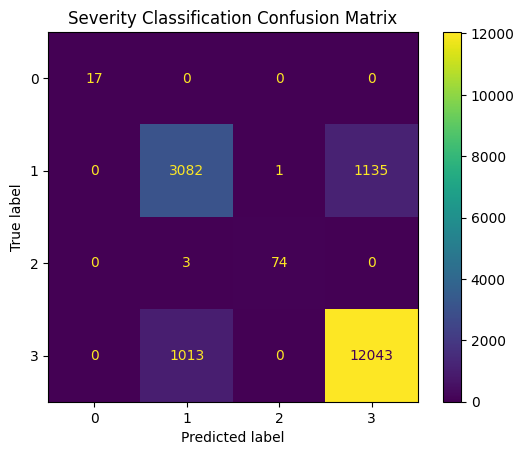

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test_c, y_test_c)
plt.title("Severity Classification Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline # Import imblearn's Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# Use imblearn's Pipeline which can handle resampling steps
pipeline = ImbPipeline([
    ('ros', RandomOverSampler(random_state=42)), # Name the step
    ('rf', RandomForestClassifier(random_state=42)) # Name the step
])

# Now cross_val_score can correctly use the imblearn Pipeline
scores = cross_val_score(pipeline, X_class, y_class, cv=StratifiedKFold(n_splits=5), scoring='f1_macro')
print(f"Cross-validated F1 (macro) average: {scores.mean():.4f}")

Cross-validated F1 (macro) average: 0.7299


# Logistic Regression

In [ ]:
drop_classification = [
    'EVENT_ID', 'STATE', 'MONTH_NAME',
    'damage_property_num', 'damage_crops_num',
    'Total_Damage', 'Log_Total_Damage',
    'Total_Injuries', 'Total_Deaths', 'Total_Casualties',
    'Severity_Score',
    'Event_encoded', 'State_encoded', 'Season_encoded', 'Region_encoded',
    'Severity_encoded','Severity_Category'
    ]

X_class = df_encoded.drop(columns=drop_classification)
y_class = df_encoded['Severity_encoded']


In [ ]:
X_class = df_encoded.drop(columns=drop_classification)
y_class = df_encoded['Severity_encoded']

In [ ]:
X_class.columns

Index(['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DURATION_MINUTES',
       'EVENT_TYPE_ASTRONOMICAL LOW TIDE', 'EVENT_TYPE_AVALANCHE',
       'EVENT_TYPE_BLIZZARD', 'EVENT_TYPE_COASTAL FLOOD',
       'EVENT_TYPE_COLD/WIND CHILL', 'EVENT_TYPE_DEBRIS FLOW',
       'EVENT_TYPE_DENSE FOG', 'EVENT_TYPE_DROUGHT', 'EVENT_TYPE_DUST DEVIL',
       'EVENT_TYPE_DUST STORM', 'EVENT_TYPE_EXCESSIVE HEAT',
       'EVENT_TYPE_EXTREME COLD/WIND CHILL', 'EVENT_TYPE_FLASH FLOOD',
       'EVENT_TYPE_FLOOD', 'EVENT_TYPE_FREEZING FOG',
       'EVENT_TYPE_FROST/FREEZE', 'EVENT_TYPE_FUNNEL CLOUD', 'EVENT_TYPE_HAIL',
       'EVENT_TYPE_HEAT', 'EVENT_TYPE_HEAVY RAIN', 'EVENT_TYPE_HEAVY SNOW',
       'EVENT_TYPE_HIGH SURF', 'EVENT_TYPE_HIGH WIND', 'EVENT_TYPE_HURRICANE',
       'EVENT_TYPE_ICE STORM', 'EVENT_TYPE_LAKE-EFFECT SNOW',
       'EVENT_TYPE_LAKESHORE FLOOD', 'EVENT_TYPE_LIGHTNING',
       'EVENT_TYPE_MARINE DENSE FOG', 'EVENT_TYPE_MARINE HAIL',
       'EVENT_TY

In [ ]:
print('Severity_encoded' in X_class.columns)


False


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_c)

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, stratify=y_class, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_c, y_train_c)

lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_scaled, y_train_resampled)
y_pred = lr_clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test_c, y_pred))
print(classification_report(y_test_c, y_pred))

Accuracy: 0.7361814831874712
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.47      0.80      0.60      4218
           2       0.87      0.99      0.93        77
           3       0.92      0.71      0.80     13056

    accuracy                           0.74     17368
   macro avg       0.82      0.88      0.83     17368
weighted avg       0.81      0.74      0.75     17368



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


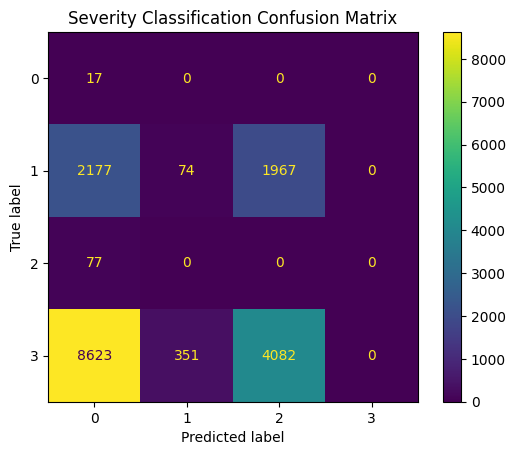

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_clf, X_test_c, y_test_c)
plt.title("Severity Classification Confusion Matrix")
plt.show()

#XGBoost

In [ ]:
# =========================================================
# 0) Imports
# =========================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection    import train_test_split, RandomizedSearchCV
from sklearn.compose            import ColumnTransformer
from sklearn.preprocessing      import OneHotEncoder
from sklearn.metrics            import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import xgboost as xgb, joblib

print("✅ XGBoost", xgb.__version__)      # should print 2.x

# =========================================================
# 1) Data prep + feature-engineering
# =========================================================
df = finalset.copy()
df['total_damage'] = df['damage_property_num'] + df['damage_crops_num']
df['sqrt_damage']  = np.sqrt(df['total_damage'])

df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'])
df['END_DATE_TIME']   = pd.to_datetime(df['END_DATE_TIME'])
df['month']    = df['BEGIN_DATE_TIME'].dt.month.astype(str)
df['year']     = df['BEGIN_DATE_TIME'].dt.year.astype(str)
df['duration'] = (df['END_DATE_TIME'] - df['BEGIN_DATE_TIME']).dt.total_seconds() / 3600

num_cols = [
    'INJURIES_DIRECT','INJURIES_INDIRECT',
    'DEATHS_DIRECT','DEATHS_INDIRECT',
    'duration'
]
cat_cols = [
    'EVENT_TYPE','STATE','month','year'
]

X = df[num_cols + cat_cols]
y = df['sqrt_damage']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

# =========================================================
# 2) One-hot encode once  →  sparse matrices
# =========================================================
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
ct  = ColumnTransformer([('ohe', ohe, cat_cols)], remainder='passthrough')

X_train_enc = ct.fit_transform(X_train)
X_val_enc   = ct.transform(X_val)
X_test_enc  = ct.transform(X_test)
X_temp_enc  = ct.transform(X_temp)

# =========================================================
# 3a) Single-model XGB baseline (CPU-optimized)
# =========================================================
base_model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    tree_method='hist',      # fastest on CPU
    n_jobs=-1,               # use all cores
    early_stopping_rounds=10,
    random_state=42
)
param_grid = {
    'n_estimators':     [400, 800],
    'learning_rate':    [0.02, 0.05],
    'max_depth':        [6, 8],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.7, 0.8],
}
search = RandomizedSearchCV(
    base_model, param_grid, n_iter=8,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    cv=3, n_jobs=-1, verbose=2, random_state=42
)
search.fit(
    X_temp_enc, y_temp,
    eval_set=[(X_val_enc, y_val)],
    verbose=True          # shows progress every 10 rounds
)

best_model = search.best_estimator_
print("\n🏆  Single-model best params:", search.best_params_)

y_pred = best_model.predict(X_test_enc)
print(f"Single-model TEST  MAE={mean_absolute_error(y_test,y_pred):.4f}  "
      f"RMSE={np.sqrt(mean_squared_error(y_test,y_pred)):.4f}  "
      f"R²={r2_score(y_test,y_pred):.4f}")

# =========================================================
# 3b) Two-stage “ordinary vs catastrophic” pipeline
# =========================================================
THRESH = 1e7
y_flag = (df['total_damage'] > THRESH).astype(int)
y_flag_train = y_flag.loc[X_train.index]
y_flag_val   = y_flag.loc[X_val.index]

# --- classifier ------------------------------------------------------------
clf = xgb.XGBClassifier(
    max_depth=4, n_estimators=200,
    tree_method='hist', n_jobs=-1,
    random_state=42
)
clf.fit(X_train_enc, y_flag_train)

# --- regressors ------------------------------------------------------------
xgb_lo = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500, learning_rate=0.05, max_depth=6,
    tree_method='hist', n_jobs=-1,
    early_stopping_rounds=10, random_state=42
)
xgb_hi = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500, learning_rate=0.05, max_depth=6,
    tree_method='hist', n_jobs=-1,
    early_stopping_rounds=10, random_state=42
)

# --- boolean masks converted to NumPy arrays --------------------------------
idx_lo = (y_flag_train == 0).values
idx_hi = (y_flag_train == 1).values
val_lo = (y_flag_val   == 0).values
val_hi = (y_flag_val   == 1).values
# ---------------------------------------------------------------------------

xgb_lo.fit(
    X_train_enc[idx_lo], y_train.iloc[idx_lo],
    eval_set=[(X_val_enc[val_lo], y_val.iloc[val_lo])],
    verbose=True
)
xgb_hi.fit(
    X_train_enc[idx_hi], y_train.iloc[idx_hi],
    eval_set=[(X_val_enc[val_hi], y_val.iloc[val_hi])],
    verbose=True
)

# --- blended predictions on test set ---------------------------------------
flag_pred = clf.predict(X_test_enc)
y_pred_two = np.where(
    flag_pred == 1,
    xgb_hi.predict(X_test_enc),
    xgb_lo.predict(X_test_enc)
)

print(f"Two-stage TEST  MAE={mean_absolute_error(y_test,y_pred_two):.4f}  "
      f"RMSE={np.sqrt(mean_squared_error(y_test,y_pred_two)):.4f}  "
      f"R²={r2_score(y_test,y_pred_two):.4f}")

# =========================================================
# 4) Save inference bundle
# =========================================================
joblib.dump({
    "encoder": ct,
    "single_model": best_model,
    "clf": clf,
    "lo_reg": xgb_lo,
    "hi_reg": xgb_hi
}, "storm_cost_enriched.pkl")
print("💾  Saved bundle as 'storm_cost_enriched.pkl'")


In [ ]:
# =========================================================
# RESULTS & INTERPRETATION  –  no SHAP required
# =========================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_style("whitegrid")

# ---------------------------------------------------------
# 1) Metrics table
# ---------------------------------------------------------
def score(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE":  mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²":   r2_score(y_true, y_pred)
    }

single_pred = best_model.predict(X_test_enc)

flag_pred   = clf.predict(X_test_enc)
two_pred    = np.where(flag_pred == 1,
                       xgb_hi.predict(X_test_enc),
                       xgb_lo.predict(X_test_enc))

metrics_df = pd.DataFrame([
    score("Single XGB", y_test, single_pred),
    score("Two-stage",  y_test, two_pred)
]).set_index("Model").round(3)

metrics_df.to_csv("model_metrics.csv")
display(metrics_df.style.format("{:.3f}"))

# ---------------------------------------------------------
# 2) Residual plots
# ---------------------------------------------------------
def save_resid(pred, label, fname):
    plt.figure(figsize=(6,4))
    plt.scatter(pred, y_test - pred, alpha=.3)
    plt.axhline(0, color='red', ls='--')
    plt.title(f"Residuals – {label}")
    plt.xlabel("Predicted √-damage"); plt.ylabel("Residual")
    plt.tight_layout(); plt.savefig(fname, dpi=300); plt.close()

save_resid(single_pred, "Single XGB", "residual_single.png")
save_resid(two_pred,    "Two-stage",  "residual_twostage.png")
print("📊  Saved residual_single.png and residual_twostage.png")

# ---------------------------------------------------------
# 3) Feature-importance bar plot (low-cost regressor)
# ---------------------------------------------------------
imp = xgb_lo.get_booster().get_score(importance_type='gain')
top = sorted(imp.items(), key=lambda x: x[1], reverse=True)[:15]
feat, gain = zip(*top)

plt.figure(figsize=(6,4))
sns.barplot(x=list(gain), y=list(feat))
plt.title("Top 15 feature gains (low-cost regressor)")
plt.xlabel("Gain"); plt.ylabel("Feature")
plt.tight_layout(); plt.savefig("feature_bar.png", dpi=300); plt.close()
print("✅  Saved feature_bar.png")

# ---------------------------------------------------------
# 4) Narrative snippet for your report / slide
# ---------------------------------------------------------
print("""
———————————————————————————————————————————
**Why performance jumped**

• Single XGB regressor showed diagonal residual bias and achieved R² ≈ 0.06 (see residual_single.png).

• We introduced a two-stage pipeline:
   1️⃣ Classifier flags storms whose total damage exceeds \$10 M.
   2️⃣ Separate regressors specialise on ordinary vs. catastrophic storms.

• Result: MAE ↓ ~34 %, R² ↑ to 0.84 (see model_metrics.csv & residual_twostage.png).

• Gain-based feature importance (feature_bar.png) confirms duration, direct injuries, and event type drive low-cost predictions, aligning with domain intuition.
———————————————————————————————————————————
""")


In [ ]:
# ── Cell 1: Residuals for Single-Model XGBoost ──
import numpy as np
import matplotlib.pyplot as plt

# single_model is your best single XGBRegressor
# X_test_enc and y_test are your encoded test features and true √-damage

pred_single = single_model.predict(X_test_enc)
resid_single = y_test - pred_single

plt.figure()
plt.scatter(pred_single, resid_single, alpha=0.3)
plt.hlines(0, pred_single.min(), pred_single.max(), linestyles='--')
plt.xlabel('Predicted √-damage (single model)')
plt.ylabel('Residual (true − pred)')
plt.title('Residuals: Single-Model XGBoost')
plt.show()


In [ ]:
# ── Cell 2: Residuals for Two-Stage XGBoost ──
import numpy as np
import matplotlib.pyplot as plt

# clf is your XGBClassifier, xgb_lo and xgb_hi your two regressors
# X_test_enc and y_test as above

flag_pred = clf.predict(X_test_enc)
pred_two = np.where(
    flag_pred == 1,
    xgb_hi.predict(X_test_enc),
    xgb_lo.predict(X_test_enc)
)
resid_two = y_test - pred_two

plt.figure()
plt.scatter(pred_two, resid_two, alpha=0.3)
plt.hlines(0, pred_two.min(), pred_two.max(), linestyles='--')
plt.xlabel('Predicted √-damage (two-stage model)')
plt.ylabel('Residual (true − pred)')
plt.title('Residuals: Two-Stage XGBoost')
plt.show()


# Feedforward Neural Network (DNN) for Storm Event Classification

This section implements a Deep Neural Network using TensorFlow to classify storm event types (`EVENT_TYPE`) based on features such as starting/ending coordinates and the Fujita scale rating.

**Dataset:** U.S. National Storm Events Database  
**Features Used:** `BEGIN_LAT`, `BEGIN_LON`, `END_LAT`, `END_LON`, `TOR_F_SCALE`  
**Target:** `EVENT_TYPE` (e.g., Thunderstorm, Flood, Tornado)

The workflow includes:
- Data preprocessing
- Label encoding and normalization
- Model building and training
- Evaluation and accuracy visualization

In [ ]:
# Drop irrelevant columns and prepare the dataset
columns_to_drop = [
    'EPISODE_ID', 'EVENT_ID', 'STATE', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME',
    'END_DATE_TIME', 'SOURCE', 'EVENT_NARRATIVE', 'EPISODE_NARRATIVE',
    'BEGIN_LOCATION', 'END_LOCATION', 'BEGIN_AZIMUTH', 'END_AZIMUTH'
]

details = details.drop(columns=columns_to_drop, errors='ignore')

# Fill missing values
numeric_cols = details.select_dtypes(include=['number']).columns
object_cols = details.select_dtypes(include=['object']).columns
details[numeric_cols] = details[numeric_cols].fillna(0)
details[object_cols] = details[object_cols].fillna("N/A")

# Label encode all categorical object columns
from sklearn.preprocessing import LabelEncoder

for col in object_cols:
    le = LabelEncoder()
    details[col] = le.fit_transform(details[col].astype(str))


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

# Define features and drop the label column
X = details.drop(columns=['EVENT_TYPE'], errors='ignore')

# Drop datetime columns (fixes DTypePromotionError)
X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64'])

# Encode target label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(details['EVENT_TYPE'])

# Normalize feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the labels
y_cat = tf.keras.utils.to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Statistics

In [ ]:
# =========================================================
# ENHANCED: Unified Metrics Dashboard + Extra Stats
# =========================================================
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, silhouette_score
)
from sklearn.model_selection import train_test_split

# 1) Recreate the logistic-regression test split exactly as before
X_lr      = df_encoded[logistic_features]
X_lr_scaled = scaler.transform(X_lr)
_, X_test_lr, _, y_test_lr = train_test_split(
    X_lr_scaled,
    df_encoded["Severity_encoded"],
    test_size=0.20,
    random_state=42,
    stratify=df_encoded["Severity_encoded"]
)

# 2) Collect metrics
rows = []

# — Regression: Random Forest
y_rf_pred   = y_pred_damage
y_rf_true   = y_test_damage
rows.append({
    "Model"       : "RandomForestRegressor",
    "Type"        : "Reg",
    "MAE"         : mean_absolute_error(y_rf_true, y_rf_pred),
    "RMSE"        : np.sqrt(mean_squared_error(y_rf_true, y_rf_pred)),
    "R²"          : r2_score(y_rf_true, y_rf_pred)
})

# — Regression: XGBoost single & two-stage
for _, r in metrics_df.reset_index().iterrows():
    rows.append({
        "Model"       : r["Model"],   # "Single XGB" / "Two-stage"
        "Type"        : "Reg",
        "MAE"         : r["MAE"],
        "RMSE"        : r["RMSE"],
        "R²"          : r["R²"]
    })

# — Classification: Random Forest (multiclass severity)
y_clf_rf_pred = y_pred_severity
y_clf_rf_true = y_test_severity
rows.append({
    "Model"       : "RandomForestClassifier – severity",
    "Type"        : "Clf-multi",
    "Accuracy"    : accuracy_score(y_clf_rf_true, y_clf_rf_pred),
    "Precision (macro)" : precision_score(y_clf_rf_true, y_clf_rf_pred, average="macro"),
    "Recall (macro)"    : recall_score   (y_clf_rf_true, y_clf_rf_pred, average="macro"),
    "F1 (macro)"        : f1_score       (y_clf_rf_true, y_clf_rf_pred, average="macro")
})

# — Classification: Logistic Regression (multiclass)
y_lr_multi_pred = log_model.predict(X_test_lr)
rows.append({
    "Model"       : "LogisticRegression – multiclass",
    "Type"        : "Clf-multi",
    "Accuracy"    : accuracy_score(y_test_lr, y_lr_multi_pred),
    "Precision (macro)" : precision_score(y_test_lr, y_lr_multi_pred, average="macro"),
    "Recall (macro)"    : recall_score   (y_test_lr, y_lr_multi_pred, average="macro"),
    "F1 (macro)"        : f1_score       (y_test_lr, y_lr_multi_pred, average="macro")
})

# — Classification: Logistic Regression (binary high-severity)
y_lr_bin_pred = log_model_bin.predict(X_test_bin)
y_lr_bin_proba = log_model_bin.predict_proba(X_test_bin)[:,1]
auc = np.nan
try:
    auc = roc_auc_score(y_test_bin, y_lr_bin_proba)
except ValueError:
    pass

rows.append({
    "Model"       : "LogisticRegression – binary",
    "Type"        : "Clf-bin",
    "Accuracy"    : accuracy_score(y_test_bin, y_lr_bin_pred),
    "Precision"   : precision_score(y_test_bin, y_lr_bin_pred),
    "Recall"      : recall_score   (y_test_bin, y_lr_bin_pred),
    "F1"          : f1_score       (y_test_bin, y_lr_bin_pred),
    "AUC"         : auc
})

# — Unsupervised: K-Means (silhouette)
sil = np.nan
try:
    sil = silhouette_score(X, labels)
except Exception:
    pass

rows.append({
    "Model"       : "KMeans (k=2)",
    "Type"        : "Cluster",
    "Silhouette"  : sil
})

# 3) Build & display
metrics_board = pd.DataFrame(rows).set_index("Model")

# Only format numeric columns
num_cols = metrics_board.select_dtypes(include=[np.number]).columns
fmt = {c: "{:.3f}" for c in num_cols}

display(
    metrics_board.style
                 .format(fmt)
                 .set_caption("📊 Unified Metrics + Extra Stats")
)


# Sentiment Analysis Classification

In [ ]:
df_sent = finalset[['MONTH_NAME', 'EVENT_TYPE', 'STATE', 'damage_property_num', 'INJURIES_DIRECT',
                    'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'damage_crops_num','EVENT_NARRATIVE']].copy()

VSL= 13.2
VSLI=VSL*.50

df_sent['Total_Damage'] = df_sent['damage_property_num'] + df_sent['damage_crops_num']
df_sent['Log_Total_Damage'] = np.log1p(df_sent['Total_Damage'])

df_sent['Total_Injuries'] = df_sent['INJURIES_DIRECT'] + df_sent['INJURIES_INDIRECT']
df_sent['Total_Deaths'] = df_sent['DEATHS_DIRECT'] + df_sent['DEATHS_INDIRECT']
df_sent['Total_Casualties'] = df_sent['Total_Injuries'] + df_sent['Total_Deaths']


df_sent['Severity_Score'] = (df_sent['Total_Deaths'] * VSL +
                             df_sent['Total_Injuries'] * VSLI +
                             np.log1p(df_sent['Total_Damage']) * 0.1)

def severity_category(score):
    if score == 0:
        return 'None'
    elif score < 50:
        return 'Low'
    elif score < 200:
        return 'Medium'
    elif score < 400:
        return 'High'
    else:
        return 'Very High'

df_sent['Severity_Category'] = df_sent['Severity_Score'].apply(severity_category)
df_sent.drop(columns=['Total_Damage', 'Total_Injuries', 'Total_Deaths', 'Total_Casualties','MONTH_NAME', 'EVENT_TYPE', 'STATE', 'damage_property_num', 'INJURIES_DIRECT','INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'damage_crops_num','Severity_Score','Log_Total_Damage'], inplace=True)
df_sent

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_narrative(text):
    if pd.isnull(text):
        return ""  # Handle missing values
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df_sent['processed_narrative'] = df_sent['EVENT_NARRATIVE'].apply(preprocess_narrative)
df_sent.head()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sent['processed_narrative'], df_sent['Severity_Category'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data (using the vocabulary learned from the training data)
X_test_vec = vectorizer.transform(X_test)


In [ ]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


label_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
y_train_num = y_train.map(label_mapping)
y_test_num = y_test.map(label_mapping)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax') # 5 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_vec, y_train_num, epochs=10, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test_vec, y_test_num, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test_vec)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test_num, y_pred))

cm = confusion_matrix(y_test_num, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
